# SECTION 1: INTRODUCTION TO PRITHVI, IBM-NASA FOUNDDATION GEOSPATIAL MODEL

## 1.1 Introduction
### 1.1.1 What is Prithvi?

Parts of this Jupyter Notebook are derived from Prithvi's [documentation](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M) web page available in Hugging Face: 

Prithvi is a Vision transformer pre-trained by IBM and NASA on contiguous US Harmonised Landsat Sentinel 2 (HLS) data. The model adopts a self-supervised encoder developed with a ViT architecture and Masked AutoEncoder (MAE) learning strategy, with an MSE loss function. The model includes spatial attention across multiple patches and also temporal attention for each patch.

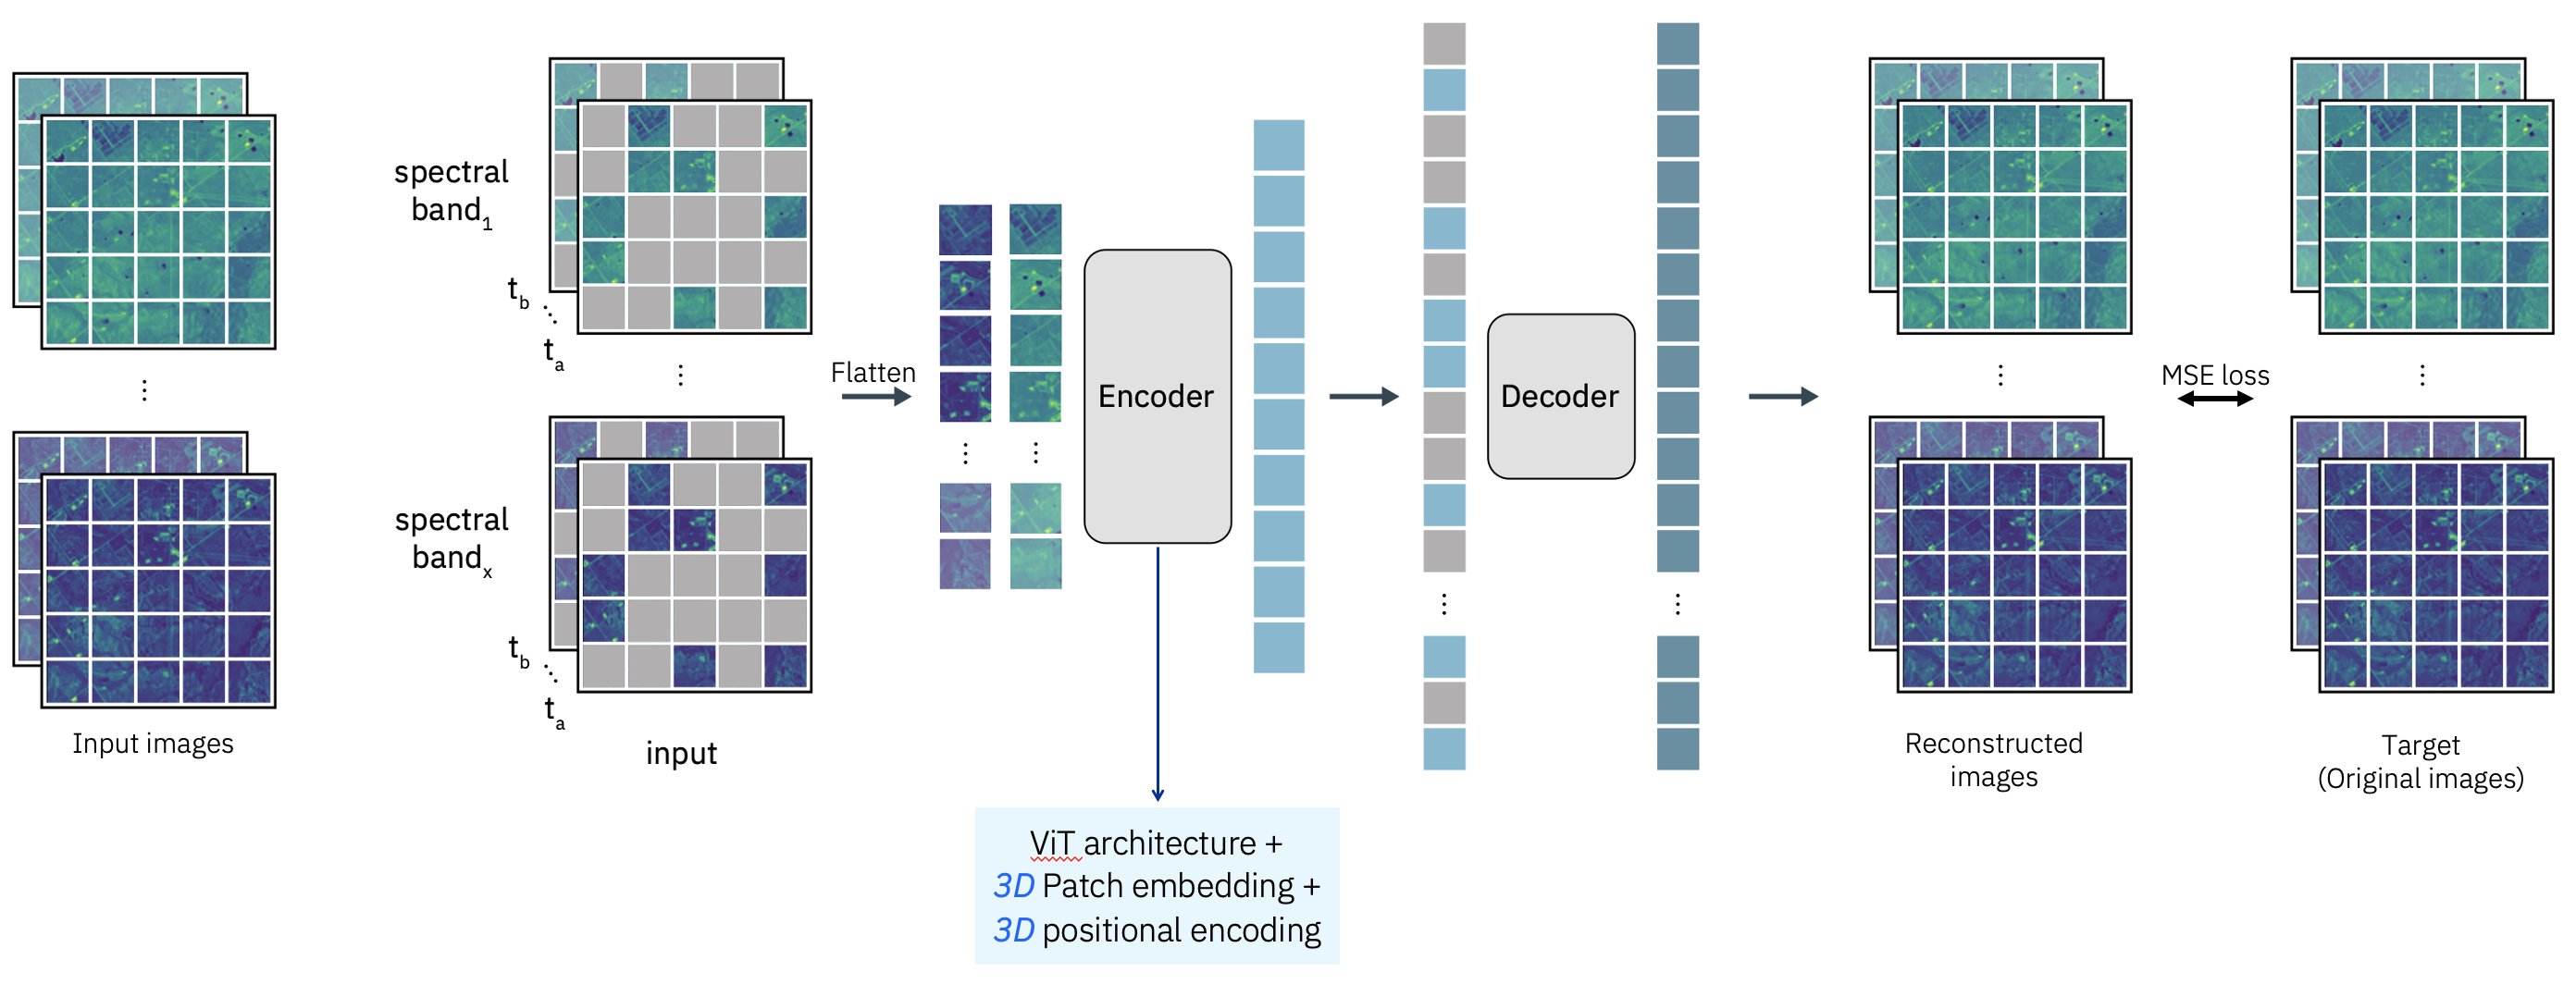

#### a. Pre-training
The model was pre-trained with NASA's HLS V2 L30 product (30m granularity) from the contiguous United States. The bands that were used are the following:

1. Blue
2. Green
3. Red
4. Narrow NIR
5. SWIR 1
6. SWIR 2

#### b. Finetuning
Examples of finetuning the model for image segmentation using the mmsegmentation library are available through Hugging Face (e.g. [burn scars segmentation](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar), [flood mapping](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-sen1floods11), and [multi temporal crop classification](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification), with the code used for the experiments available on github. This also contains instructions to finetune the model for flood detection on the popular open access sen1floods11 dataset.

### 1.1.2 Multi-temporal Crop Classification
The pretrained Prithvi-100m parameter model is finetuned to classify crop and other land cover types based off HLS data and CDL labels from the [multi_temporal_crop_classification](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification) dataset.

This dataset includes input chips of 224x224x18, where 224 is the height and width and 18 is combined with 6 bands of 3 time-steps. The bands are:

1. Blue
2. Green
3. Red
4. Narrow NIR
5. SWIR 1
6. SWIR 2

Labels are from CDL(Crop Data Layer) and classified into 13 classes:
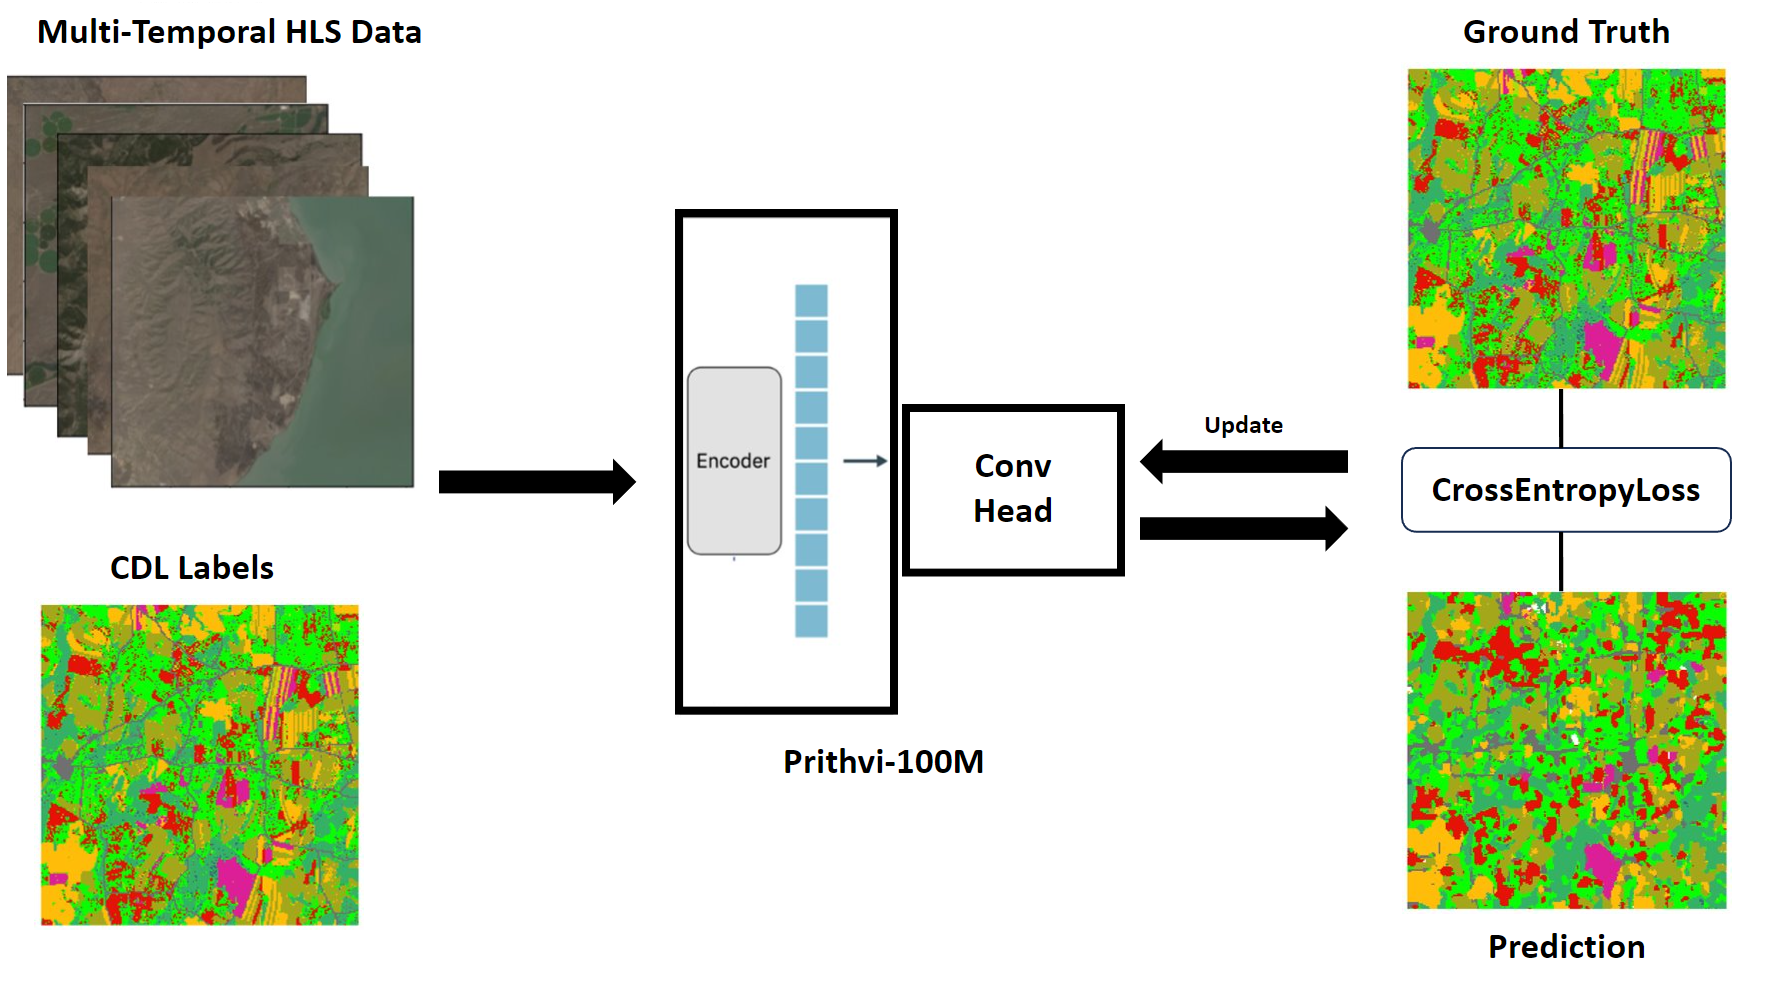

#### a. Results
The experiment by running the mmseg stack for 80 epochs using the above config led to the following result:The experiment by running the mmseg stack for 80 epochs using the above config led to the following result:

| Classes | IoU | Acc |
|------------|----|----|
| Natural Vegetation | 0.4038 | 46.89% |
| Forest | 0.4747 | 66.38% |
| Corn | 0.5491 | 65.47% |
| Soybeans | 0.5297 | 67.46% | 
| Wetlands | 0.402 | 58.91% |
| Developed/Barren | 0.3611 | 56.49% |
| Open Water | 0.6804 | 90.37% |
| Winter Wheat | 0.4967 | 67.16% |
| Alfalfa | 0.3084 | 66.75% |
| Fallow/Idle Cropland | 0.3493	| 59.23% |
| Cotton | 0.3237 | 66.94% |
| Sorghum | 0.3283 | 73.56% |
| Other | 0.3427 | 47.12% |

| aAcc | mIoU |	mAcc |
|------|------|------|
| 60.64% | 0.4269 | 64.06% |

## 1.2 Installation and setup

### 1.2.1 Dependencies
1. Clone this github repository: https://github.com/NASA-IMPACT/hls-foundation-os/tree/main
```bash
git clone https://github.com/NASA-IMPACT/hls-foundation-os.git
```

**IMPORTANT**: Once you cloned the repository, make sure that you have the folder structure below

    Main Folder/
    ├── geopspatial_fm/*
    ├── prithvi/*
    ├── README.md
    └── setup.py

- setup.py is used to install the *geospatial_fm* packages
- README.md is used by setup.py
- *prithvi* folder is used in both finetuning and inference tasks

2. Create a new conda environment:

```bash
cat > .condarc <<EOF
envs_dirs:
  - /home/jovyan/my-conda-envs/
EOF

conda create py310 python=3.10
conda activate py310
```

3. Setup the environment for Jupyter Notebook.
python -m ipykernel install --user --name py310 --display-name "py310"er --name py310 --display-name py310
```

4. Install torch (tested for >=1.7.1 and <=1.11.0) and torchvision (tested for >=0.8.2 and <=0.12). May vary with your system. Please check at: https://pytorch.org/get-started/previous-versions/. Example:

```bash
pip install torch==1.11.0+cu115 torchvision==0.12.0+cu115 --extra-index-url https://download.pytorch.org/whl/cu115
```

6. Install the following:
```bash
cd hls-foundation-os
pip install -e .
pip install -U openmim
```

7. Instammcvmie:
```bash
pip install numpy==1.* opencv-python==4.9.*
mim install mmcv-full==1.6.2 -f https://download.openmmlab.com/mmcv/dist/cu115/torch1.11.0/index.html
```

8. Install the Prithvi foundation model.
```bash
conda install git-lfs
git lfs install
git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M
mv Prithvi-100M prithvi 
cd prithvi
git config --global --add safe.directory /home/jovyan/prithvi
git checkout c2435ef
```

9. Install p rasterio rasterioackages for geospatial data processing.
```bash
pip install geopandas
```


# SECTION 2. A SIMPLE EXAMPLE OF FINE-TUNING

## 2.1 PREPROCESSING SPOT IMAGE AND LAND USE DATA FOR 2-CLASS FINETUNING

### 2.1.1 Introduction
This notebook guides you through preprocessing SPOT satellite imagery and corresponding Land use (LU) map to prepare a dataset for fine-tuning the Prithvi model. The steps include  visualizing data, stacking image bands, calculating spectral indices, cropping images, creating patches, and splitting data into training, validation, and testing sets.

This notebook provides a hands-on guide to preprocessing SPOT satellite imagery and Land use map to create a dataset for fine-tuning the Prithvi model. The preprocessing pipeline includes visualizing Land use map, calculating spectral indices (NDVI and NDWI) and stacking multi-temporal SPOT image bands, cropping images to a common extent, generating patches, and splitting the dataset into training, validation, and testing sets. T

### 2.1.2 Main objective
To preprocess SPOT satellite imagery and Land use map to produce a dataset suitable for fine-tuning the Prithvi model for accurate land use classification.

#### Specific objectives
By the end of this module, learners will be able to:

- Visualize a Land use map and interpret its attribute table to understand land cover classes.
- Compute spectral indices (NDVI, NDWI) and stack SPOT image bands from multiple years (2016, 2020, 2022).
- Crop the stacked SPOT imagery to align with the Land use data extent, ensuring spatial consistency for analysis.
- Generate fixed-size image and label patches (e.g., 224x224 pixels) from SPOT and Land use map for Prithvi model compatibility.
- Split the dataset into training (70%), validation (10%), and testing (20%) sets to support model development and evaluation.

### 2.1.3 Prerequisites
To follow this module, learners should have:
- Basic understanding of remote sensing and Geographic Information Systems (GIS) concepts (e.g., satellite imagery, coordinate systems).
- Familiarity with geospatial data formats (e.g., GeoTIFF for rasters, Shapefile for vectors).
- Basic Python programming skills and familiarity with libraries like Rasterio, Geopandas, NumPy, and Matplotlib. Advanced Python expertise is not required.
- A Python environment with required libraries installed (see setup instructions at PART 00).

### 2.1.4 Required inputs
- **SPOT Imagery**: Three SPOT images from Khon Kaen, Thailand (2016, 2020, 2022), each with 6 bands (e.g., Red, Green, Blue, NIR, NDVI, and NDWI)
- **Land Use Data**: A Land use shapefile (e.g. gt_LU2022A.shp) matching the SPOT imagery’s extent.
- **Python Environment**: Installed with packages including `rasterio`, `geopandas`, `numpy`, `matplotlib`, and `tqdm`.

**Important Notes**:
1. This module uses sample data from Khon Kaen, Thailand. For larger regions, create a mosaic of SPOT images before preprocessing.
2. Ensure SPOT imagery and Land Use data share the same CRS to avoid spatial misalignment during processing.
3. This notebook assumes access to the sample data paths provided (e.g., `/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/`). Adjust paths as needed for your environment.

##### Visualizing the Land Use Map

In this step, we load and visualize the Land use map for Khon Kaen, Thailand, and examine its attribute table. The dataset includes 2 land use classes, as shown below:

| Land Use        | Raster Value | Color Code |
|-----------------|--------------|------------|
| Forest          | 1            | Green      |
| Agricultural    | 2            | Yellow     |

In [3]:
!wget https://rgw.glodal-inc.net/public/250721-2-class.zip && unzip 250721-2-class.zip

--2025-07-20 22:02:31--  https://rgw.glodal-inc.net/public/250721-2-class.zip
Resolving rgw.glodal-inc.net (rgw.glodal-inc.net)... 104.26.11.146, 104.26.10.146, 172.67.69.25, ...
Connecting to rgw.glodal-inc.net (rgw.glodal-inc.net)|104.26.11.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500389255 (477M) [application/octet-stream]
Saving to: ‘250721-2-class.zip’

250721-2-class.zip  100%[===================>] 477.21M  1.55MB/s    in 5m 2s   

2025-07-20 22:07:34 (1.58 MB/s) - ‘250721-2-class.zip’ saved [500389255/500389255]

Archive:  250721-2-class.zip
   creating: 2-class/
  inflating: 2-class/gt_LU2022A.sbn  
 extracting: 2-class/gt_LU2022A.cpg  
  inflating: 2-class/gt_LU2022A.prj  
  inflating: 2-class/gt_LU2022A.sbx  
  inflating: 2-class/gt_LU2022A.shp.xml  
  inflating: 2-class/gt_LU2022A.shx  
  inflating: 2-class/gt_LU2022A.shp  
  inflating: 2-class/gt_LU2022A.dbf  
  inflating: 2-class/img_SPOT2022A.tif  


In [46]:
import os

# Define paths and create output directory
place_name = 'Khon_Kaen_2class'
output_folder = place_name
os.makedirs(output_folder, exist_ok=True)

spot_images_folder_path = '2-class'
lu_shp_path = '2-class/gt_LU2022A.shp'
landuse_path = os.path.join(output_folder, 'gt_LU2022A_raster_2class.tif')

In [47]:
import os
import pandas as pd
import geopandas as gpd

%time

# Validate shapefile existence
if not os.path.exists(lu_shp_path):
    raise FileNotFoundError(f"Shapefile not found: {lu_shp_path}")

# Define bounding box
bbox = (102.36639, 16.56754, 102.37659, 16.57427)
    
# Read shapefile
gdf = gpd.read_file(lu_shp_path)
print("No of rows:", len(gdf))
print("CRS:", gdf.crs)

# Display first 5 rows
gdf.head()

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 5.48 μs
No of rows: 2462
CRS: EPSG:32648


OBJECTID  LU_ID_L1  LU_ID_L2  LU_ID_L3 LU_CODE                 LU_DES_TH  \
0         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
1         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
2        15       2.0      21.0    2100.0    A100                    นาร้าง   
3        15       2.0      21.0    2100.0    A100                    นาร้าง   
4        15       2.0      21.0    2100.0    A100                    นาร้าง   

                          LU_DES_EN LUL1_CODE LUL2_CODE LU_DES  Shape_Area  \
0  Integrated farm/Diversified farm         A        A0   None    0.007101   
1  Integrated farm/Diversified farm         A        A0   None    0.025581   
2             Abandoned paddy field         A        A1   None    0.016422   
3             Abandoned paddy field         A        A1   None    0.043954   
4             Abandoned paddy field         A        A1   None    0.013321   

   RAI  CLASS                                           geometry  
0    4      0  POLYGON ((231497.851 1834335.859, 231454.977 1...  
1   16      0  POLYGON ((230660.195 1840495.116, 230664.482 1...  
2   10      0  POLYGON ((225305.412 1829638.89, 225300.4 1829...  
3   27      0  POLYGON ((216539.782 1829843.363, 216541.543 1...  
4    8      0  POLYGON ((226837.388 1830329.971, 226814.688 1...

In [48]:
final_lu_code = []
final_lu_class = []

for row in gdf.itertuples():
    if row.LUL1_CODE == 'F':
        final_lu_code.append(1)
        final_lu_class.append("FOR")
        
    elif row.LUL1_CODE == 'A':
        final_lu_code.append(2)
        final_lu_class.append("AGR")

    else:
        final_lu_code.append(0)
        final_lu_class.append("X")

gdf['final_lu_code'] = final_lu_code
gdf['final_lu_class'] = final_lu_class

gdf.head()

OBJECTID  LU_ID_L1  LU_ID_L2  LU_ID_L3 LU_CODE                 LU_DES_TH  \
0         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
1         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
2        15       2.0      21.0    2100.0    A100                    นาร้าง   
3        15       2.0      21.0    2100.0    A100                    นาร้าง   
4        15       2.0      21.0    2100.0    A100                    นาร้าง   

                          LU_DES_EN LUL1_CODE LUL2_CODE LU_DES  Shape_Area  \
0  Integrated farm/Diversified farm         A        A0   None    0.007101   
1  Integrated farm/Diversified farm         A        A0   None    0.025581   
2             Abandoned paddy field         A        A1   None    0.016422   
3             Abandoned paddy field         A        A1   None    0.043954   
4             Abandoned paddy field         A        A1   None    0.013321   

   RAI  CLASS                                           geometry  \
0    4      0  POLYGON ((231497.851 1834335.859, 231454.977 1...   
1   16      0  POLYGON ((230660.195 1840495.116, 230664.482 1...   
2   10      0  POLYGON ((225305.412 1829638.89, 225300.4 1829...   
3   27      0  POLYGON ((216539.782 1829843.363, 216541.543 1...   
4    8      0  POLYGON ((226837.388 1830329.971, 226814.688 1...   

   final_lu_code final_lu_class  
0              2            AGR  
1              2            AGR  
2              2            AGR  
3              2            AGR  
4              2            AGR

In [49]:
# Converting Land use shapefile to raster
import rasterio as rio
from rasterio.features import rasterize
import glob

%time

# define reference raster path
spot_imgs_path = glob.glob(spot_images_folder_path + '/*.tif')[0] # e.g. "SPOT/A/SPOT/img_SPOT2020A.tif"

# Extract metadata from the reference SPOT image
with rio.open(spot_imgs_path) as ref_raster:
    # get the details of the reference raster
    crs = ref_raster.crs
    transform = ref_raster.transform
    width = ref_raster.width
    height = ref_raster.height
    dtype = ref_raster.dtypes[0]

# check if gdf and spot image have the same crs
print("SPOT CRS:",crs)
print("LU CRS:",gdf.crs)

# Reproject Land Use data if CRS does not match
if gdf.crs != crs:
    print("CRS mismatch, reprojecting")
    gdf = gdf.to_crs(crs)
    print("Updated LU CRS:",gdf.crs)

# Rasterize the Land use shapefile
with rio.open(landuse_path, 'w', driver='GTiff',
                   count=1, dtype=dtype, crs=crs,
                   width=width, height=height, transform=transform, compress='Deflate') as dst:

    rasterized = rasterize(
        ((geom, value) for geom, value in zip(gdf.geometry, gdf['final_lu_code'])),
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Fill value for empty pixels
        dtype=dtype
    )
    
    # Write the rasterized data to the output raster
    dst.write(rasterized, 1)

print(f"Land Use raster saved to: {landuse_path}")

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs
SPOT CRS: EPSG:4326
LU CRS: EPSG:32648
CRS mismatch, reprojecting
Updated LU CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Land Use raster saved to: Khon_Kaen_2class/gt_LU2022A_raster_2class.tif


CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs
Raster CRS: EPSG:4326


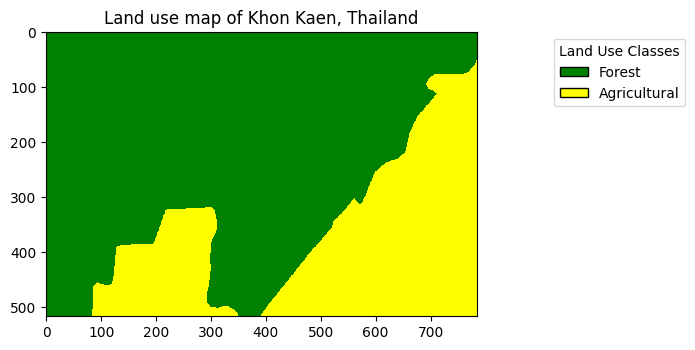

In [50]:
# Visualizing the Land use raster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.windows import from_bounds

%time

# Read the rasterized Land Use data within the bounding box
with rio.open(landuse_path) as src:
    window = from_bounds(*bbox, transform=src.transform)
    raster_data = src.read(1, window=window) #read just the 1st band
    crs = src.crs
     
print("Raster CRS:",crs) #check the coordinate reference system of the raster file
    
# Colors are assigned based on value / Landuse type
value_to_color = {
    1:'green',
    2:'yellow'}

# create a colormap with these values
colors = ['green', 'yellow']  # index 0 = value 1, index 1 = value 2
cmap = ListedColormap(colors)

# Create the visualization
plt.figure(figsize=(8, 8))
plt.imshow(raster_data, cmap=cmap, interpolation='none')

# Define legend labels
lu_legend = {1:'Forest',
             2:'Agricultural'}

# Add legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                   for value, color in value_to_color.items()]
plt.legend(handles=legend_elements, title="Land Use Classes", loc='upper right', bbox_to_anchor=(1.5, 1))

plt.title("Land use map of Khon Kaen, Thailand")

# Show the plot
plt.tight_layout()
plt.show()

##### Stacking SPOT images and calculating spectral indices

This section processes SPOT images by:
- **Calculating spectral indices**:
  - **NDVI**: Measures vegetation health using the formula: `NDVI = (NIR - Red) / (NIR + Red)`.
  - **NDWI**: Detects water content using the formula: `NDWI = (Green - NIR) / (Green + NIR)`.
- **Multi-temporal stacking**: Combining SPOT images from 2022, 2020, and 2016, each with 6 bands (4 original + NDVI + NDWI), resulting in an 18-band composite image.

**Note**: This process may take up to 5 minutes depending on the image size and computational resources.

In [51]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds

def calculate_indices(image_path, window=None):
    with rasterio.open(image_path) as src:
        if window:
            blue = src.read(1, window=window).astype(float)
            green = src.read(2, window=window).astype(float)
            red = src.read(3, window=window).astype(float)
            nir = src.read(4, window=window).astype(float)
        else:
            blue = src.read(1).astype(float)
            green = src.read(2).astype(float)
            red = src.read(3).astype(float)
            nir = src.read(4).astype(float)
        meta = src.meta
    ndvi = (nir - red) / (nir + red)
    ndwi = (green - nir) / (green + nir)
    return ndvi, ndwi, meta

def process_and_stack_images(folder_path, output_path, bbox):
    image_files = [
        os.path.join(folder_path, "img_SPOT2022A.tif"),
        #os.path.join(folder_path, "img_SPOT2020A.tif"),
        #os.path.join(folder_path, "img_SPOT2016A.tif")
    ]
    # Verify all images exist
    missing_files = [f for f in image_files if not os.path.exists(f)]
    if missing_files:
        raise FileNotFoundError(f"Missing images: {missing_files}")
    print(f"Processing images in order: {image_files}")
    all_bands = []
    first_transform = None
    for image_path in image_files:
        print(f"Processing {image_path}...")
        with rasterio.open(image_path) as src:
            window = from_bounds(*bbox, transform=src.transform)
            bands = [src.read(i, window=window) for i in [3, 2, 1, 4]]
            if not first_transform:
                first_transform = src.window_transform(window)
            if any(np.any(band == src.nodata) for band in bands):
                raise ValueError(f"No-data values found in {image_path}")
            meta = src.meta
        ndvi, ndwi, _ = calculate_indices(image_path, window=window)
        all_bands.extend(bands + [ndvi, ndwi])
    meta.update({
        'count': len(all_bands),
        'dtype': 'float32',
        'height': bands[0].shape[0],
        'width': bands[0].shape[1],
        'transform': first_transform,
        'compress': 'Deflate'
    })
    os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
    print(f"Saving stacked image to {output_path}...")
    with rasterio.open(output_path, 'w', **meta) as dst:
        for idx, band in enumerate(all_bands, start=1):
            dst.write(band.astype(np.float32), idx)
    print("Done with calculating and stacking all bands!")

# Define output path for the stacked image
%time
stacked_spot_image =os.path.join(output_folder,"stack_2classes.tif" ) # give file name to stack image
process_and_stack_images(spot_images_folder_path, stacked_spot_image, bbox)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.25 μs
Processing images in order: ['2-class/img_SPOT2022A.tif']
Processing 2-class/img_SPOT2022A.tif...
Saving stacked image to Khon_Kaen_2class/stack_2classes.tif...
Done with calculating and stacking all bands!



Image shape: (6, 518, 785)


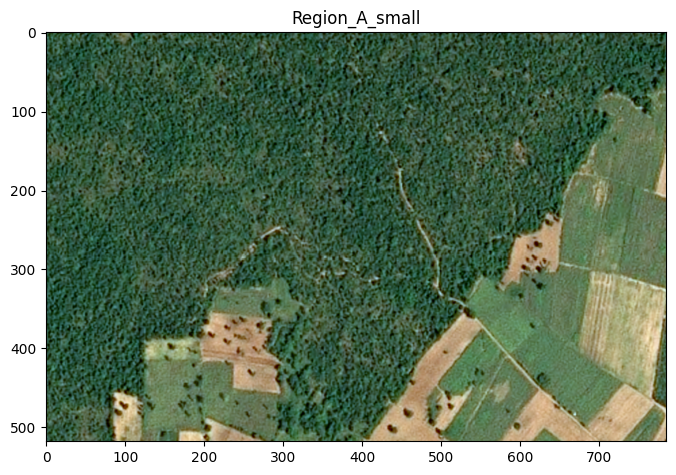

CPU times: user 514 ms, sys: 101 ms, total: 614 ms
Wall time: 410 ms


In [52]:
%%time
# Visualizing Bangkok and Ubon-Ratchathani
# ESTIMATED RUNTIME: <1 minute, if the cell runs for more than 1min, restart the kernel

import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the sample rasters
A_path  =  "Khon_Kaen_2class/stack_2classes.tif"

def visualize_raster(raster_path,name):
    with rio.open(raster_path) as src:
        data = src.read()
        print("\nImage shape:",data.shape) #check if the target images has 18bands

        # visualize the HLS file
        #rgb = src.read([3,2,1]) # change to [3,2,1] for RGB. [4,3,2] shows False Color
        rgb = src.read([1,2,3]) # change to [3,2,1] for RGB. [4,3,2] shows False Color

        # scale to 0-255 for visualization
        scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

        for i in range(3):
            band = rgb[i]
            min_val = np.min(band[band > 0]) #
            max_val = np.max(band[band > 0]) # band > 0 will select pixel values that are positive
            scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)

        scaled_rgb_new = scaled_rgb.transpose((1,2,0))

        # display the RGB image
        plt.figure(figsize=(8,8))
        plt.imshow(scaled_rgb_new)
        plt.title(name)
        plt.show()
        
# Visualize SPOT image
visualize_raster(A_path,"Region_A_small")

In [53]:
# Importing required libraries for cropping and patch creation
import rasterio as rio
from rasterio.mask import mask
from rasterio.windows import Window
from shapely.geometry import box
import geopandas as gpd
import os
import numpy as np
from tqdm import tqdm

#### Cropping SPOT imagery to land use extent
This section crops the stacked SPOT imagery to match the spatial extent of the Land use data, ensuring that the imagery covers only the relevant study area. The output is an 18-band image aligned with the Land use raster.

#### Creating image and Label patches
This section generates 224x224 pixel patches from both the SPOT imagery and Land use raster, ensuring correspondence between image and label patches for training.

In [54]:
# Clipping imagery to a reference extent
def clip_to_reference_extent(source_path, reference_path, output_path):
    """Clip the source image to the extent of the reference image."""
    print(f"Clipping {os.path.basename(source_path)} to reference extent...")
    with rio.open(reference_path) as ref:
        ref_bounds = ref.bounds
        ref_bbox = box(ref_bounds.left, ref_bounds.bottom, ref_bounds.right, ref_bounds.top)
        ref_gdf = gpd.GeoDataFrame({'geometry': [ref_bbox]}, crs=ref.crs)
    
    with rio.open(source_path) as src:
        ref_gdf = ref_gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, ref_gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print("Clipping completed!")

In [162]:
# Creating random patches from SPOT and Land use data
def create_rm_patches(img_path, ann_path, img_output_dir, ann_output_dir, num_patches, patch_size=112, prefix="patch"):
    """Generate random patches from image and annotation rasters."""
    os.makedirs(img_output_dir, exist_ok=True)
    os.makedirs(ann_output_dir, exist_ok=True)
    
    with rio.open(img_path) as img, rio.open(ann_path) as ann:
        img_bands = img.count
        ann_bands = ann.count
        img_profile = img.profile
        ann_profile = ann.profile
        width, height = img.width, img.height

        for i in range(num_patches):
            x = np.random.randint(0, width - patch_size)
            y = np.random.randint(0, height - patch_size)
            print(f"Patch {i+1} Coordinates: ({x}, {y})")

            window = Window(x, y, patch_size, patch_size)
            img_patch_data = img.read(window=window)
            ann_patch_data = ann.read(window=window)

            img_output_path = os.path.join(img_output_dir, f'{prefix}_tile-{x:03d}-{y:03d}.tif')
            ann_output_path = os.path.join(ann_output_dir, f'{prefix}_tile-{x:03d}-{y:03d}.tif')
            img_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, img.transform)
            })
            ann_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, ann.transform)
            })

            with rio.open(img_output_path, 'w', **img_profile) as dst:
                dst.write(img_patch_data)
            with rio.open(ann_output_path, 'w', **ann_profile) as dst:
                dst.write(ann_patch_data)

In [56]:
# Processing images and creating patches
import os
import shutil

def process_images(landuse_path, spot_path, output_base_dir):
    """Clip Land Use to SPOT extent and create patches."""
    print("Starting image processing...")
    
    landuse_patches_dir = os.path.join(output_base_dir, 'landuse_patches_2class')
    spot_patches_dir = os.path.join(output_base_dir, 'spot_patches_2class')
    clipped_landuse_path = os.path.join(output_base_dir, 'clipped_landuse_2class.tif')
    
    # Clip Land Use to SPOT extent
    clip_to_reference_extent(landuse_path, spot_path, clipped_landuse_path)
    
    # Create patches
    shutil.rmtree(landuse_patches_dir, ignore_errors=True)
    shutil.rmtree(spot_patches_dir, ignore_errors=True)
    create_rm_patches(spot_path, clipped_landuse_path, spot_patches_dir, landuse_patches_dir, 100)
    print("Image processing completed successfully!")

In [57]:
# Executing image processing
import shutil

process_images(
    landuse_path=landuse_path,
    spot_path=stacked_spot_image,
    output_base_dir=output_folder
)

Starting image processing...
Clipping gt_LU2022A_raster_2class.tif to reference extent...
Clipping completed!
Patch 1 Coordinates: (102, 348)
Patch 2 Coordinates: (270, 106)
Patch 3 Coordinates: (71, 188)
Patch 4 Coordinates: (20, 102)
Patch 5 Coordinates: (121, 214)
Patch 6 Coordinates: (330, 87)
Patch 7 Coordinates: (372, 99)
Patch 8 Coordinates: (663, 130)
Patch 9 Coordinates: (661, 308)
Patch 10 Coordinates: (343, 293)
Patch 11 Coordinates: (385, 191)
Patch 12 Coordinates: (276, 160)
Patch 13 Coordinates: (459, 313)
Patch 14 Coordinates: (21, 252)
Patch 15 Coordinates: (560, 58)
Patch 16 Coordinates: (510, 169)
Patch 17 Coordinates: (475, 187)
Patch 18 Coordinates: (189, 174)
Patch 19 Coordinates: (562, 363)
Patch 20 Coordinates: (566, 243)
Patch 21 Coordinates: (504, 130)
Patch 22 Coordinates: (484, 306)
Patch 23 Coordinates: (646, 20)
Patch 24 Coordinates: (166, 273)
Patch 25 Coordinates: (387, 88)
Patch 26 Coordinates: (315, 13)
Patch 27 Coordinates: (241, 264)
Patch 28 Coordina

In [58]:
# Filtering patches to ensure correct dimensions
def filter_patch_images(image_folder):
    """Remove patches that do not match the desired size (224x224)."""
    desired_width, desired_height = 112, 112 # 224, 224 #
    deleted_files = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
    
    for image_file in tqdm(image_files, desc="Processing Images", unit="image"):
        image_path = os.path.join(image_folder, image_file)
        try:
            with rio.open(image_path) as src:
                width, height = src.width, src.height
                if (width, height) != (desired_width, desired_height):
                    os.remove(image_path)
                    deleted_files.append(image_file)
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("\nSummary:")
    print(f"Total images processed: {len(image_files)}")
    print(f"Images deleted: {len(deleted_files)}")
    if deleted_files:
        print("Deleted files:")
        for file in deleted_files:
            print(f"- {file}")

# Filter SPOT and Land use patches
landuse_patch_folder = os.path.join(output_folder, 'landuse_patches_2class')
spot_patch_folder = os.path.join(output_folder, 'spot_patches_2class')
filter_patch_images(spot_patch_folder)
filter_patch_images(landuse_patch_folder)

Processing Images: 100%|██████████| 100/100 [00:00<00:00, 323.80image/s]



Summary:
Total images processed: 100
Images deleted: 0


Processing Images: 100%|██████████| 100/100 [00:00<00:00, 360.81image/s]


Summary:
Total images processed: 100
Images deleted: 0


#### Splitting Data into Training, Validation, and Testing Sets

To support robust model development, the dataset is split into:
- **Training Set (70%)**: Used to train the model.
- **Validation Set (10%)**: Used to tune hyperparameters and monitor training performance.
- **Testing Set (20%)**: Used for final evaluation of the trained model on unseen data.

The split ensures that image and label patches remain paired across all sets.

In [59]:
# Splitting patches into training, validation, and testing sets
import os
import shutil
import random
import numpy as np

def create_train_val_test_splits(
    image_dir, 
    mask_dir, 
    output_dir,
    train_ratio=0.70,
    val_ratio=0.10,
    test_ratio=0.20,
    random_seed=42
):
    """Split image and mask patches into training, validation, and testing sets."""
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Create directories for splits
    splits = ['train', 'val', 'test']
    for split in splits:
        for subdir in ['images', 'masks']:
            os.makedirs(os.path.join(output_dir, split, subdir), exist_ok=True)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    random.shuffle(image_files)
    
    total_size = len(image_files)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]
    
    def copy_files(file_list, split_name):
        print(f"Copying {split_name} files...")
        for filename in file_list:
            src_image = os.path.join(image_dir, filename)
            dst_image = os.path.join(output_dir, split_name, 'images', filename)
            shutil.copy2(src_image, dst_image)
            src_mask = os.path.join(mask_dir, filename)
            dst_mask = os.path.join(output_dir, split_name, 'masks', filename)
            shutil.copy2(src_mask, dst_mask)
    
    split_files = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }
    
    for split_name, files in split_files.items():
        copy_files(files, split_name)
        print(f"{split_name} split: {len(files)} images")

    return {
        'train_size': len(train_files),
        'val_size': len(val_files),
        'test_size': len(test_files)
    }

# Create final training data directory and perform splitting
final_training_data_folder = os.path.join(output_folder, 'final_training_data_2class')
shutil.rmtree(final_training_data_folder, ignore_errors=True)
os.makedirs(final_training_data_folder, exist_ok=True)

stats = create_train_val_test_splits(
    image_dir=spot_patch_folder,
    mask_dir=landuse_patch_folder,
    output_dir=final_training_data_folder,
    train_ratio=0.70,
    val_ratio=0.10,
    test_ratio=0.20,
    random_seed=42
)

print("\nData Split Summary:")
print(f"Total images: {sum(stats.values())}")
for split_name, size in stats.items():
    print(f"{split_name.capitalize()}: {size} images")

Copying train files...
train split: 70 images
Copying val files...
val split: 10 images
Copying test files...
test split: 20 images

Data Split Summary:
Total images: 100
Train_size: 70 images
Val_size: 10 images
Test_size: 20 images


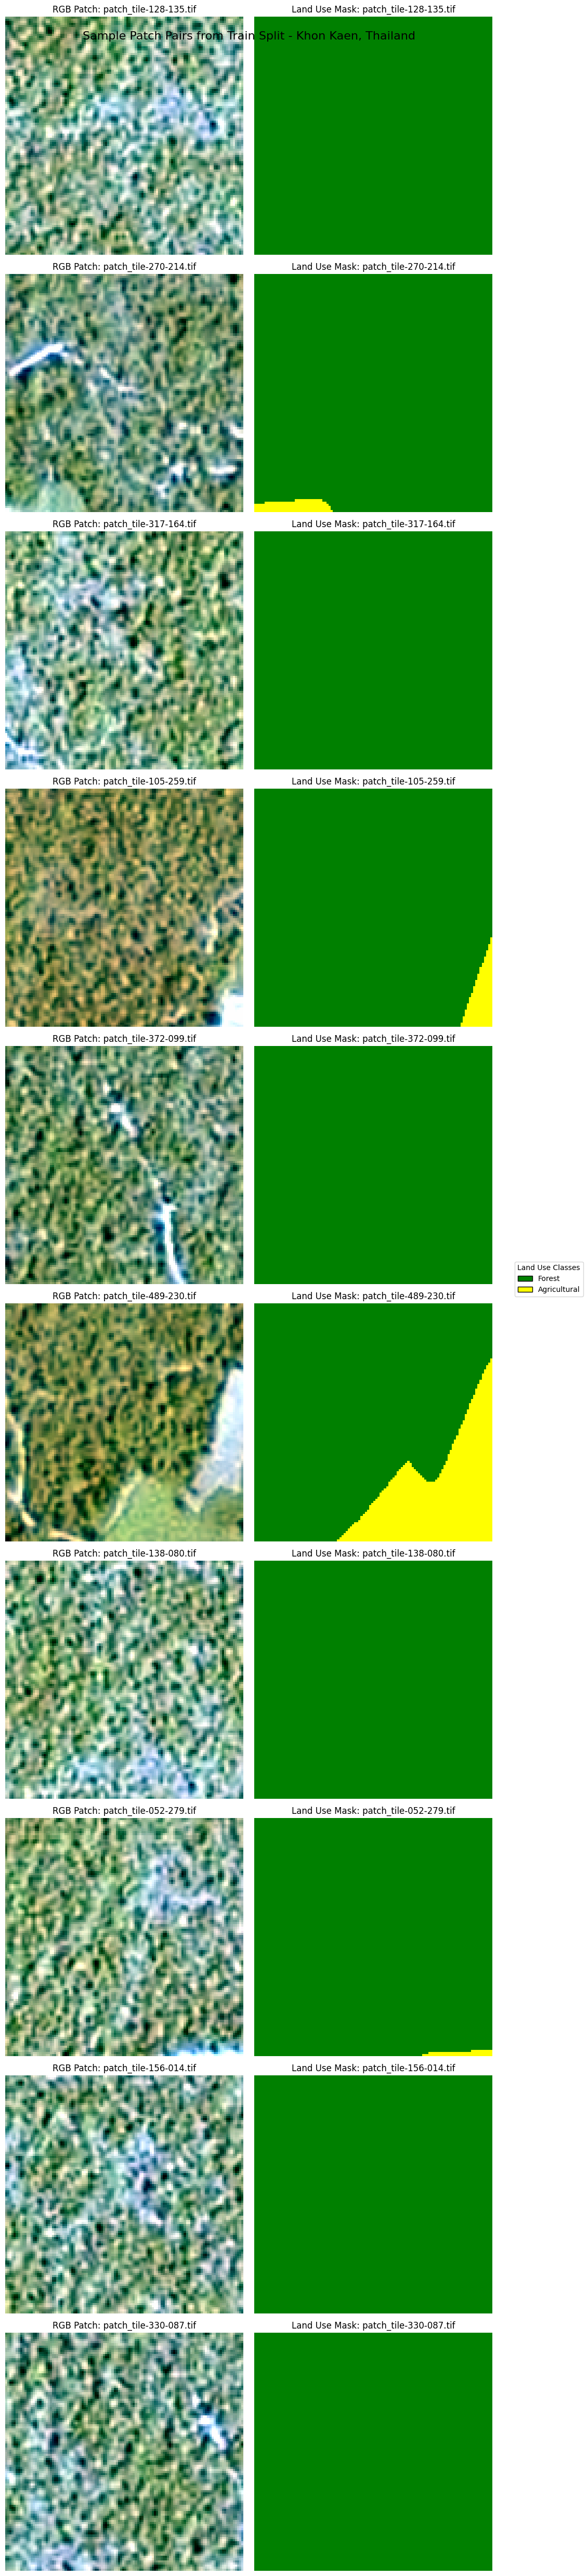

Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. Do the patches look consistent across splits? How do the Land Use classes vary in different patches?


In [60]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import random
import os

def visualize_sample_patches(output_dir, split='train', num_samples=6, random_seed=42):
    """
    Visualize a few sample image and mask patch pairs from a specified split.

    Parameters:
    - output_dir: Path to the final training data directory (e.g., 'final_training_data').
    - split: Split to visualize ('train', 'val', or 'test'). Default is 'train'.
    - num_samples: Number of patch pairs to display. Default is 3.
    - random_seed: Random seed for reproducibility. Default is 42.
    """
    # Validate inputs
    if split not in ['train', 'val', 'test']:
        raise ValueError(f"Invalid split: {split}. Choose 'train', 'val', or 'test'.")
    image_dir = os.path.join(output_dir, split, 'images')
    mask_dir = os.path.join(output_dir, split, 'masks')
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Image or mask directory not found in {output_dir}/{split}")

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    if len(image_files) < num_samples:
        raise ValueError(f"Requested {num_samples} samples, but only {len(image_files)} available in {split} split.")

    # Randomly select sample files
    random.seed(random_seed)
    sample_files = random.sample(image_files, num_samples)

    # Land Use class mapping and colors (from earlier notebook section)
    lu_classes = {
        1: 'Forest', 2: 'Agricultural'
    }
    lu_colors = {
        1: 'green', 2: 'yellow'
    }
    #cmap = ListedColormap([lu_colors[i] for i in range(1, 7)])
    cmap = ListedColormap([lu_colors[i] for i in sorted(lu_colors)])

    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for single sample

    for i, filename in enumerate(sample_files):
        # Read image patch
        image_path = os.path.join(image_dir, filename)
        with rasterio.open(image_path) as src:
            if src.count < 3:
                raise ValueError(f"Image {filename} has fewer than 3 bands.")
            blue = src.read(1).astype(float)  # Band 1: Blue
            green = src.read(2).astype(float)  # Band 2: Green
            red = src.read(3).astype(float)  # Band 3: Red
            nodata = src.nodata if src.nodata is not None else 0

        # Normalize RGB bands for display
        def normalize_band(band):
            band = np.where(band == nodata, np.nan, band)
            band = np.clip(band, 0, np.nanpercentile(band, 99))  # Clip outliers
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            return (band - band_min) / (band_max - band_min + 1e-10) if band_max > band_min else band

        red_norm = normalize_band(red)
        green_norm = normalize_band(green)
        blue_norm = normalize_band(blue)
        rgb = np.dstack((red_norm, green_norm, blue_norm))

        # Read mask patch
        mask_path = os.path.join(mask_dir, filename)
        with rasterio.open(mask_path) as src:
            if src.count != 1:
                raise ValueError(f"Mask {filename} should have 1 band, found {src.count}.")
            mask = src.read(1).astype(float)
            mask = np.where(mask == nodata, np.nan, mask)

        # Plot image and mask
        axes[i][0].imshow(rgb)
        axes[i][0].set_title(f"RGB Patch: {filename}")
        axes[i][0].axis('off')

        #mask_im = axes[i][1].imshow(mask, cmap=cmap, vmin=1, vmax=6)
        mask_im = axes[i][1].imshow(mask, cmap=cmap, vmin=1, vmax=len(lu_classes))
        axes[i][1].set_title(f"Land Use Mask: {filename}")
        axes[i][1].axis('off')

    # Add legend for Land Use classes
    legend_elements = [
        Patch(facecolor=lu_colors[i], edgecolor='black', label=lu_classes[i])
        for i in sorted(lu_classes)
    ]
    fig.legend(handles=legend_elements, title="Land Use Classes", loc='center right',
               bbox_to_anchor=(1.15, 0.5))

    plt.suptitle(f"Sample Patch Pairs from {split.capitalize()} Split - Khon Kaen, Thailand", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Interactive Exercise for Training
    print("Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. "
          "Do the patches look consistent across splits? How do the Land Use classes vary in different patches?")

# Visualize 3 sample patch pairs from the train split
final_training_data_folder = os.path.join(output_folder, 'final_training_data_2class')
visualize_sample_patches(final_training_data_folder, split='train', num_samples=10, random_seed=42)

## 2.2 MODEL FINETUNING FOR 2-CLASS LAND USE CLASSIFICATION OF SPOT IMAGES

### 2.2.1 Introduction
This notebook guides you through fine-tuning a pretrained **Temporal Vision Transformer (TemporalViT)** model to classify land use from multi-temporal SPOT satellite imagery, focusing on a dataset from Khon Kaen, Thailand. Fine-tuning leverages pretrained weights (Prithvi-100M) to adapt the model to our specific task, improving accuracy for land use classes (Forest, Agricultural) using imagery from 2016, 2020, and 2022. The process includes configuring the model, customizing the backbone, defining class-specific loss functions, and optimizing training parameters.

#### a. Why Fine-Tune a Pretrained Model Instead of Training from Scratch for Land Use Classification?
Fine-tuning a pretrained model is preferred because it:
- Avoids training from scratch, which requires massive labeled datasets and high computational power.
- Leverages pre-learned spatial and temporal representations.
- Starts with a model already familiar with remote sensing data.

In this workflow, we use the Prithvi-100M pretrained weights. This model has been trained on diverse satellite imagery, enabling it to capture general patterns that transfer effectively to our specific region (e.g., Khon Kaen) and task (land use classification).

#### b. Benefits of Using Pretrained Models
Using a pretrained model offers several key benefits:
- **Faster Convergence**: Learns faster due to existing knowledge of patterns.
- **Reduced Overfitting**: Better generalization with fewer labeled samples.
- **Improved Accuracy**: Performs better on real-world imagery with limited training data.
- **Transferable Knowledge**: Can be fine-tuned for new regions, sensors, or land use types.

This is why our strategy emphasizes fine-tuning rather than training from scratch.

#### c. Why Use This Model?
We chose the **Temporal Vision Transformer (TemporalViTEncoder)** because it:
- Supports multi-frame input, ideal for our three-year SPOT image stack.
- Captures temporal changes, such as seasonal or yearly land cover shifts.
- Is fully compatible with the pretrained Prithvi model.
- Handles high-dimensional multi-band data better than classical CNNs.

This module guides you through fine-tuning a pretrained TemporalViT to classify land use in a targeted region using multi-year SPOT imagery. You will learn how to configure the model, apply proper normalization, define class-specific loss functions, and optimize the training process for high performance on a real-world remote sensing classification task.

### 2.2.2 Main Objective
Fine-tune a pretrained TemporalViT model to achieve optimal land use classification performance for multi-temporal SPOT imagery.

#### Specific Objectives
By the end of this module, learners will be able to:
- Define the model parameters for 2-class classification.
- Ensure compatibility with the preprocessed dataset (`final_training_data` directory).

### 2.2.3 Prerequisites
To successfully complete this module, learners should have:
- A basic understanding of remote sensing and deep learning concepts (e.g., neural networks, loss functions).
- Familiarity with Python and libraries like `MMSegmentation`.
- A Python environment with required libraries installed and access to a GPU for training.

### 2.2.4 Required Inputs
- **Stacked SPOT Image**: A multi-band GeoTIFF (`stack.tif`) with 18 bands (6 bands × 3 years).
- **Training, Validation, and Test Datasets**: Image and mask patch pairs in `final_training_data/train`, `final_training_data/val`, and `final_training_data/test` directories, generated from the previous notebook.
- **Pretrained Model Weights**: Prithvi-100M weights located at `/prithvi/Prithvi_100M.pt`.

#### Set up the model configuration
In this step, learners prepare the foundational structure for training. This includes setting up paths for data, experiments, and model outputs, as well as importing necessary modules and initializing critical parameters.

Key elements include:

- Setting data_root, project_dir, and work_dir
- Defining the number of input frames (num_frames) and patch size (img_size)
- Loading pretrained model weights (pretrained_weights_path)
- Defining normalization values using the input image (img_stack)
- Selecting image bands and constructing data pipelines (train_pipeline and test_pipeline)

This step ensures that all subsequent training components know where to find the data and how to handle it.

#### Customize the Temporal Vision Transformer (ViT) backbone
Learners can tailor the backbone of the model — the TemporalViTEncoder — to match the temporal and spectral characteristics of SPOT imagery.

Key configurable parameters include:
- patch_size: spatial subdivision of each input image
- tubelet_size: temporal grouping across frames (1 means treating each time-step separately)
- in_chans: number of bands per frame (e.g., 6: RGB, NIR, NDVI, NDWI)
- num_frames: how many time steps to consider (e.g., 3 years of SPOT imagery)
- embed_dim, num_layers, and num_heads: ViT architectural choices that determine how deep and expressive the model is

This step is crucial for capturing temporal patterns and multi-spectral information that improve land use classification accuracy over time.

#### Define land use classes and Loss functions
This step prepares the model to correctly learn from labeled land use (LU) data. Learners define which classes to predict and how to handle training imbalance using specialized loss functions.

Key components:
- CLASSES: a list of class labels (["FOR", "AGR"] for forest, agricultural)
- loss_func: typically a Focal Loss, which focuses learning on difficult examples and balances class representation
    - gamma: controls how much to down-weight easy examples
    - alpha: sets weights for each class (important if one class is more dominant)

Correctly configuring the loss function is critical for improving performance on underrepresented classes like rare land types.

#### Optimize training parameters
In this step, learners define how the training loop behaves — including optimizer, learning rate schedule, checkpointing, and evaluation.

Key components:
- optimizer: defines the algorithm (e.g., AdamW) used to adjust weights
    - Includes lr, weight_decay, and betas
- lr_config: configures how the learning rate changes over time (e.g., poly decay with warmup)
- runner & max_epochs: define the number of training iterations
- checkpoint_config: manages model saving frequency and location
- evaluation: defines how often and by what metric (e.g., mIoU) model performance is assessed

This step balances training efficiency, convergence, and model generalization.

In [61]:
%%writefile finetuning_config_spot_2class.py

import os, rasterio

experiment = 'exp01_2class' #"<experiment name>"
data_root = 'Khon_Kaen_2class/final_training_data_2class' #<path to data root>
project_dir = 'spot_a_training_2class' #"<project directory name>"
work_dir = os.path.join(project_dir, experiment)
save_path = work_dir
img_stack = 'Khon_Kaen_2class/stack_2classes.tif'

dist_params = dict(backend="nccl")
log_level = "INFO"
load_from = None
resume_from = None
cudnn_benchmark = True
custom_imports = dict(imports=["geospatial_fm"])
num_frames = 1
img_size = 224 # Patch size for 2-class example
num_workers = 1

### MODEL PARAMETERS
pretrained_weights_path = "/home/jovyan/prithvi/Prithvi_100M.pt"
num_layers = 12
patch_size = 16
embed_dim = 768
num_heads = 12
tubelet_size = 1
max_epochs = 50
eval_epoch_interval = 1

loss_weights_multi = [1.0, 1.0]  # Equal weights for 2 classes
CLASSES = ("FOR", "AGR")  # Forest, Agricultural

loss_func = dict(
    type="FocalLoss",
    gamma=2.0,
    alpha=loss_weights_multi,
)

output_embed_dim = embed_dim * num_frames

dataset_type = "GeospatialDataset"

img_norm_cfg = dict(
    means=rasterio.open(img_stack).read().mean(axis=(1,2)).tolist(),
    stds=rasterio.open(img_stack).read().std(axis=(1,2)).tolist(),
)

bands = [1, 2, 3, 4, 5, 6]
tile_size = 224
orig_nsize = 512
crop_size = (tile_size, tile_size)
train_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="LoadGeospatialAnnotations", reduce_zero_label=True),
    dict(type="RandomFlip", prob=0.5),
    dict(type="RandomRotate", prob=0.5, degree=10),
    dict(type="ToTensor", keys=["img", "gt_semantic_seg"]),
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="TorchRandomCrop", crop_size=crop_size),
    dict(type="Reshape", keys=["img"], new_shape=(len(bands), num_frames, tile_size, tile_size)),
    dict(type="Reshape", keys=["gt_semantic_seg"], new_shape=(1, tile_size, tile_size)),
    dict(type="CastTensor", keys=["gt_semantic_seg"], new_type="torch.LongTensor"),
    dict(type="Collect", keys=["img", "gt_semantic_seg"]),
]

test_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="ToTensor", keys=["img"]),
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="Reshape", keys=["img"], new_shape=(len(bands), num_frames, -1, -1), look_up=dict({"2": 1, "3": 2})),
    dict(type="CastTensor", keys=["img"], new_type="torch.FloatTensor"),
    dict(type="CollectTestList", keys=["img"], meta_keys=[
        "img_info", "seg_fields", "img_prefix", "seg_prefix", "filename",
        "ori_filename", "img", "img_shape", "ori_shape", "pad_shape",
        "scale_factor", "img_norm_cfg",
    ]),
]

data = dict(
    samples_per_gpu=1,
    workers_per_gpu=1,
    train=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='train/images',
        ann_dir='train/masks',
        pipeline=train_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    val=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='val/images',
        ann_dir='val/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    test=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='test/images',
        ann_dir='test/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
)

optimizer = dict(type="AdamW", lr=1e-6, betas=(0.9, 0.999), weight_decay=0.05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy="poly",
    warmup="linear",
    warmup_iters=500,
    warmup_ratio=1e-06,
    power=1.0,
    min_lr=0.0,
    by_epoch=False,
)

log_config = dict(
    interval=10, hooks=[dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook")]
)

checkpoint_config = dict(by_epoch=True, interval=5, out_dir=save_path)
evaluation = dict(
    interval=eval_epoch_interval,
    metric="mIoU",
    pre_eval=True,
    save_best="mIoU",
    by_epoch=True,
)
reduce_train_set = dict(reduce_train_set=False)
reduce_factor = dict(reduce_factor=1)
runner = dict(type="EpochBasedRunner", max_epochs=max_epochs)
workflow = [("train", 1)]
norm_cfg = dict(type="BN", requires_grad=True)

model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=12,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=embed_dim * num_frames,
        output_embed_dim=output_embed_dim,
        drop_cls_token=True,
        Hp=7,  # Adjusted for 112x112 patches
        Wp=7,
    ),
    decode_head=dict(
        num_classes=2,
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        loss_decode=loss_func,
    ),
    auxiliary_head=dict(
        num_classes=2,
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=2,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        loss_decode=loss_func,
    ),
    train_cfg=dict(),
    test_cfg=dict(
        mode="slide",
        stride=(int(tile_size / 2), int(tile_size / 2)),
        crop_size=(tile_size, tile_size),
    ),
)

auto_resume = False

Overwriting finetuning_config_spot_2class.py


#### Training the 2-Class Model

This section runs the fine-tuning process for the 2-class model using the MMSegmentation framework. The training should complete in 15-30 minutes on a GPU, achieving 80-90% overall accuracy.

**Steps**:
1. Run the training script using the `mim train` command.
2. Monitor the training logs for mIoU and accuracy metrics.
3. The best model checkpoint (based on mIoU) will be saved in `spot_a_training_2class/exp01_2class/`.

**Note**: Ensure you have a GPU available and the `final_trai_2classning_data` directory contains the preprocessed

#### Evaluation of Fine-Tuned Models

This section evaluates the fine-tuned models (2-class) on their respective test sets to report metrics such as mean Intersection over Union (mIoU) and overall accuracy. The evaluation uses the test patches in `final_training_data_2class/test`.

**Objectives**:
- Compute mIoU and accuracy for the 2-class

**Required Inputs**:
- Fine-tuned model checkpoints (e.g., `spot_a_training_2class/exp01_2class/best_mIoU_epoch_X.pth` for 2 classes).
- Test dataset in `final_training_data_2class/test`.
- Configuration files (`finetuning_config_spot_2class.py`). patches.

In [62]:
!pip install -U openmim

In [63]:
!mim train mmsegmentation finetuning_config_spot_2class.py

The codebase mmsegmentation is not installed, do you want to install the latest release?  [y/N]: ^C
Aborted!


## 2.3 USING 2-CLASS FINETUNE PRITHVI MODEL FOR INFERENCE

### 2.3.1 Introduction
This notebook demonstrates how to use a fine-tuned **Temporal Vision Transformer (Prithvi)** model to perform land use classification on multi-temporal SPOT satellite imagery for Khon Kaen, Thailand. Inference involves applying the model to a stacked SPOT image (18 bands: 6 bands × 3 years) to generate a land use map with classes: Forest and Agricultural. This module covers visualizing the input image, running inference, and visualizing the predicted land use map, enabling applications in urban planning, agriculture, and environmental monitoring.

#### What is inferencing?

According to [NVIDIA](https://developer.nvidia.com/topics/ai/ai-inference), Inference (Machine Learning / AI) *"is the process of generating outputs from a model by providing it inputs. There are numerous types of data inputs and outputs—such as images, text, or video—that are used to produce applications such as a weather forecast or a conversation with a large language model (LLM)."*

For our specific use case, Inferencing is the part where we use the finetuned Prithvi model to predict land use classes based on the 2 classes we used for training. To recap, the 2 classes that we have are:

| Land Use | Raster Value | Color Code |
|----------|----|----|
| Forest | 1 | green |
| Agricultural | 2 | yellow |

### Main objective
Generate a land use classification map using a fine-tuned Prithvi model on multi-temporal SPOT imagery.

#### Specific objectives
By the end of this module, learners will be able to:
- Visualize the input SPOT image to verify its band configuration and spatial extent.
- Perform inference on SPOT imagery using the fine-tuned Prithvi model to predict land use classes.
- Visualize and interpret the predicted land use map alongside the input image.

## Prerequisites
To successfully complete this module, learners should have:
- Basic understanding of remote sensing and deep learning concepts (e.g., neural networks, inference).
- Familiarity with Python and libraries like `MMSegmentation`.
- A Python environment with required libraries installed and access to a GPU for faster inference.

## Required inputs
- **Fine-Tuned Model Checkpoint**: A `.pth` file (e.g., `spot_a_training_2class/exp01_2class/best_mIoU_epoch_X.pth`).
- **Stacked SPOT Image**: A multi-band GeoTIFF (`stack_2class.tif`) with 18 bands.
- **Configuration File**: The `finetuning_config_spot_2class.py`.

### Visualize the sample SPOT image
Before running inference, it's good practice to visualize the input data. This helps confirm that the image is loaded correctly, has the expected band configuration (e.g., 18 bands), and its spatial characteristics are as anticipated. Since an 18-band image cannot be directly visualized as an RGB image, you'll typically select a subset of bands (e.g., the RGB bands from one of the years) to create a true or false-color composite for display.


Image shape: (6, 518, 785)


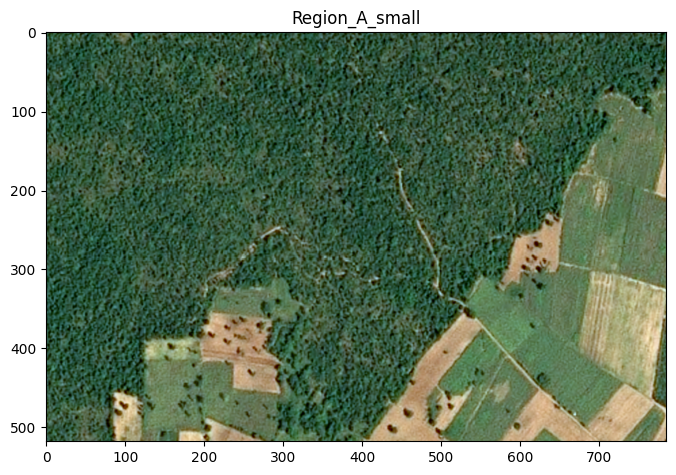

CPU times: user 583 ms, sys: 160 ms, total: 743 ms
Wall time: 522 ms


In [70]:
%%time
# Visualizing Bangkok and Ubon-Ratchathani
# ESTIMATED RUNTIME: <1 minute, if the cell runs for more than 1min, restart the kernel

import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the sample rasters
input_spot_path  =  "Khon_Kaen_2class/stack_2classes.tif"

def visualize_raster(raster_path,name):
    with rio.open(raster_path) as src:
        data = src.read()
        print("\nImage shape:",data.shape) #check if the target images has 18bands

        # visualize the HLS file
        #rgb = src.read([3,2,1]) # change to [3,2,1] for RGB. [4,3,2] shows False Color
        rgb = src.read([1,2,3]) # change to [3,2,1] for RGB. [4,3,2] shows False Color

        # scale to 0-255 for visualization
        scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

        for i in range(3):
            band = rgb[i]
            min_val = np.min(band[band > 0]) #
            max_val = np.max(band[band > 0]) # band > 0 will select pixel values that are positive
            scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)

        scaled_rgb_new = scaled_rgb.transpose((1,2,0))

        # display the RGB image
        plt.figure(figsize=(8,8))
        plt.imshow(scaled_rgb_new)
        plt.title(name)
        plt.show()
        
# Visualize SPOT image
visualize_raster(input_spot_path,"Region_A_small")

#### Inference land use of SPOT image
This is the core step of the inference process. It involves loading your saved model and feeding it the prepared SPOT image data.

**Running the actual inferencing**

IMPORTANT: Due to a relatively long code, the succeeding cells should be executed/run in sequence as we run the inference cell by cell.

In [71]:
%%time
# ESTIMATED RUNTIME: <1 minute

import os
import glob
import time

import numpy as np
import rasterio
import torch
from mmcv import Config
from mmcv.parallel import collate, scatter
from mmseg.apis import init_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile

## DEFINE PARAMETERS, change the paths as necessary
config_path = 'finetuning_config_spot_2class.py'
ckpt = 'spot_a_training_2class/exp01_2class/best_mIoU_epoch_49.pth' ###### TO SPECIFY THE MODEL FILE *.pth ######
input_path = 'Khon_Kaen_2class/' # path to input images folder for inference
input_type = 'tif' #file type of input images
output_path = 'inference_outputs' #path to save output image
bands = None # bands in the file where to find the relevant data, type = int. Use only if there are specific bands in the target dataset where the data is
device = 'cuda' #default value is cuda, change accordingly

## ACTUAL INFERENCE
#### STEP 1: load the model
print("\n>>> Step 1: Loading the model <<<")
config = Config.fromfile(config_path)
config.model.backbone.pretrained = None
model = init_segmentor(config, ckpt, device)

#### STEP 2: locate the target images
print("\n>>> Step 2: Locate the target images <<<")
target_images = glob.glob(os.path.join(input_path, "*." + input_type))
print("No of target images:",len(target_images))

# check if output folder available
if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
#### STEP 3: Test Pipeline
#NOTE:THIS IS ONLY FOR IMAGES THAT HAVE SPECIFIC TARGET BANDS
print("\n>>> Step 3: Modify the test pipeline if necessary <<<")

def process_test_pipeline(custom_test_pipeline, bands=None):
    # change extracted bands if necessary
    if bands is not None:
        extract_index = [
            i for i, x in enumerate(custom_test_pipeline) if x["type"] == "BandsExtract"
        ]

        if len(extract_index) > 0:
            custom_test_pipeline[extract_index[0]]["bands"] = bands

    collect_index = [
        i for i, x in enumerate(custom_test_pipeline) if x["type"].find("Collect") > -1
    ]

    # adapt collected keys if necessary
    if len(collect_index) > 0:
        keys = [
            "img_info",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ]
        custom_test_pipeline[collect_index[0]]["meta_keys"] = keys

    return custom_test_pipeline

# run the function
custom_test_pipeline = process_test_pipeline(model.cfg.data.test.pipeline, bands)


>>> Step 1: Loading the model <<<


/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


load checkpoint from local path: spot_a_training_2class/exp01_2class/best_mIoU_epoch_49.pth

>>> Step 2: Locate the target images <<<
No of target images: 3

>>> Step 3: Modify the test pipeline if necessary <<<
CPU times: user 3.14 s, sys: 2.31 s, total: 5.45 s
Wall time: 8.17 s


In [72]:
%%time
# ESTIMATED RUNTIME: 6 - 15 minutes
# Some parts of the code are from the model_inference.py script available from the Prithvi github
# IMPORTANT: The larger the image for prediction, the more memory and CPU utilization is expected. Runtime also takes a lot longer

#### STEP 4: Iterate prediction for every output image
print("\n>>> Step 4: Iterate prediction for every output image <<<")

# define a function to open/read a tif file
def open_tiff(fname):
    with rasterio.open(fname, "r") as src:
        data = src.read()

    return data

# define a function to write a tif file
def write_tiff(img_wrt, filename, metadata):
    """
    It writes a raster image to file.

    :img_wrt: numpy array containing the data (can be 2D for single band or 3D for multiple bands)
    :filename: file path to the output file
    :metadata: metadata to use to write the raster to disk
    :return:
    """

    with rasterio.open(filename, "w", **metadata) as dest:
        if len(img_wrt.shape) == 2:
            img_wrt = img_wrt[None]

        for i in range(img_wrt.shape[0]):
            dest.write(img_wrt[i, :, :], i + 1)

    return filename

# define a function get the metadata of an image
def get_meta(fname):
    with rasterio.open(fname, "r") as src:
        meta = src.meta

    return meta

# define function to perform inference
def inference_segmentor(model, imgs, custom_test_pipeline=None):
    """Inference image(s) with the segmentor.

    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = (
        [LoadImageFromFile()] + cfg.data.test.pipeline[1:]
        if custom_test_pipeline == None
        else custom_test_pipeline
    )
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = []
    imgs = imgs if isinstance(imgs, list) else [imgs]
    for img in imgs:
        img_data = {"img_info": {"filename": img}}
        img_data = test_pipeline(img_data)
        data.append(img_data)
    # print(data.shape)

    data = collate(data, samples_per_gpu=len(imgs))
    if next(model.parameters()).is_cuda:
        # data = collate(data, samples_per_gpu=len(imgs))
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        # img_metas = scatter(data['img_metas'],'cpu')
        # data['img_metas'] = [i.data[0] for i in data['img_metas']]

        img_metas = data["img_metas"].data[0]
        img = data["img"]
        data = {"img": img, "img_metas": img_metas}

    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

# define function to perform inference on each target file
def inference_on_file(model, target_image, output_image, custom_test_pipeline):
    time_taken = -1
    try:
        st = time.time()
        print("Running inference...")
        result = inference_segmentor(model, target_image, custom_test_pipeline)
        print("Output has shape: " + str(result[0].shape))

        # get metadata mask
        mask = open_tiff(target_image)
        meta = get_meta(target_image)
        mask = np.where(mask == meta["nodata"], 1, 0)
        mask = np.max(mask, axis=0)[None]

        result[0] = np.where(mask == 1, -1, result[0])

        # sve file to disk
        meta["count"] = 1
        meta["dtype"] = "int16"
        meta["compress"] = "lzw"
        meta["nodata"] = -1
        print("Saving output...")
        write_tiff(result[0], output_image, meta)
        et = time.time()
        time_taken = np.round(et - st, 1)
        print(
            f"Inference completed in {str(time_taken)} seconds. Output available at: "
            + output_image
        )

    except:
        print(f"Error on image {target_image} \nContinue to next input")

    return time_taken

# for each image predict and save to disk
for i, target_image in enumerate(target_images):
    print("\n> Working on Image {} <".format(i+1))
    output_image = os.path.join(
        output_path,
        target_image.split("/")[-1].replace(
            "." + input_type, "_pred." + input_type
        ),
    )
    
    inference_on_file(model,
                      target_image,
                      output_image,
                      custom_test_pipeline)


>>> Step 4: Iterate prediction for every output image <<<

> Working on Image 1 <
Running inference...
Error on image Khon_Kaen_2class/clipped_landuse_2class.tif 
Continue to next input

> Working on Image 2 <
Running inference...
Error on image Khon_Kaen_2class/gt_LU2022A_raster_2class.tif 
Continue to next input

> Working on Image 3 <
Running inference...
Output has shape: (518, 785)
Saving output...
Inference completed in 3.7 seconds. Output available at: inference_outputs/stack_2classes_pred.tif
CPU times: user 3.53 s, sys: 960 ms, total: 4.49 s
Wall time: 4.48 s


#### Visualize inference output
Visualizing the output is crucial for understanding your model's performance and identifying any misclassifications or patterns. The inferred land use map will be a raster where each pixel is assigned a predicted land use class ID. You'll use a colormap to represent these different classes visually, making the map interpretable.

Raster CRS: EPSG:4326


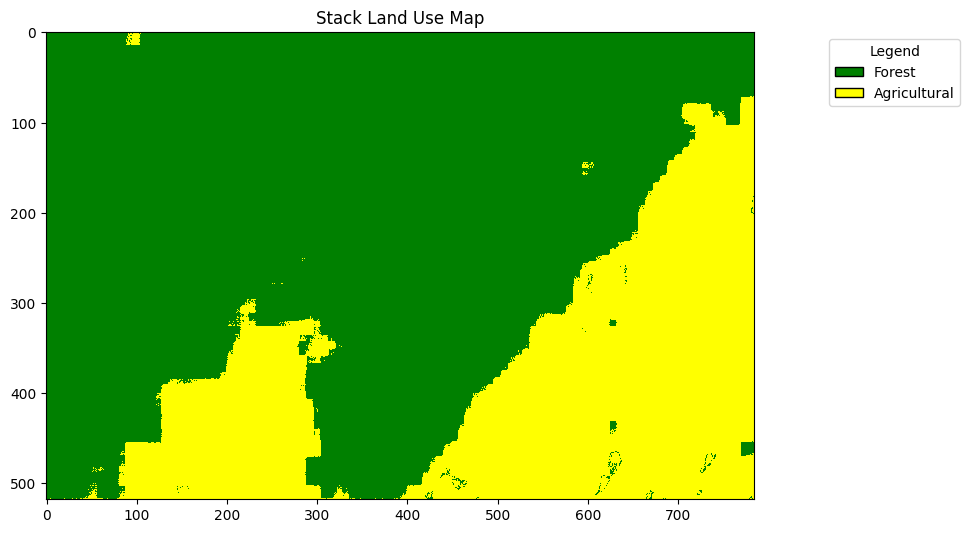

CPU times: user 548 ms, sys: 140 ms, total: 687 ms
Wall time: 348 ms


In [74]:
%%time
## Visualizing outputs for Bangkok and Ubon-Ratchathani
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Step 1: read the raster file
# IMPORTANT: Make sure that the paths contain the output inference images
sA_outpath = "inference_outputs/stack_2classes_pred.tif"

def visualize_lu_raster(raster_path, region):
    # Step 1: Read the raster
    with rio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the 1st band
        crs = src.crs

    print("Raster CRS:", crs)  # Check the coordinate reference system

    # Step 2: Mask out values not in [0, 1]
    raster_data[~np.isin(raster_data, [0, 1])] = 0

    # Step 3: Define the colormap
    value_to_color = {
        1: 'green',  # Forest
        2: 'yellow'   # Agricultural
    }

    # create a colormap with these values
    colors = ['green', 'yellow']  # index 0 = value 1, index 1 = value 2
    cmap = ListedColormap(colors)

    # Step 4: Display the raster
    plt.figure(figsize=(10, 10))
    plt.title(f"{region} Land Use Map")
    plt.imshow(raster_data, cmap=cmap, interpolation='none')

    # Step 5: Add legend
    lu_legend = {
        1: 'Forest',
        2: 'Agricultural'
    }

    legend_elements = [Patch(facecolor=value_to_color[val], edgecolor='black', label=lu_legend[val])
                       for val in value_to_color]
    plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()

# Visualize the outputs
visualize_lu_raster(sA_outpath, "Stack")


# SECTION 3. A PRACTICAL EXAMPLE OF FINE-TUNING

## 3.1 PREPROCESSING SPOT IMAGE AND LAND USE DATA FOR 6-CLASS FINETUNING

For our specific use case, Inferencing is the part where we use the finetuned Prithvi model to predict land use classes based on the 6 classes we used for training. To recap, the 6 classes that we have are:

| Land Use | Raster Value | Color Code |
|----------|----|----|
| Urban | 1 | red |
| Agricultural | 2 | yellow |
| Forest | 3 | green |
| Water | 4 | blue |
| Oil Palm | 5 | purple |
| Para Rubber | 6 | pink |",nce."ge."

### Required Inputs
- **SPOT Imagery**: Three SPOT images from Khon Kaen, Thailand (2016, 2020, 2022), each with 6 bands (e.g., Red, Green, Blue, NIR, NDVI, and NDWI)
- **Land Use Data**: A Land use shapefile (e.g. gt_LU2022A.shp) matching the SPOT imagery’s extent.
- **Python Environment**: Installed with packages including `rasterio`, `geopandas`, `numpy`, `matplotlib`, and `tqdm`.

**Important Notes**:
1. This module uses sample data from Khon Kaen, Thailand. For larger regions, create a mosaic of SPOT images before preprocessing.
2. Ensure SPOT imagery and Land Use data share the same CRS to avoid spatial misalignment during processing.
3. This notebook assumes access to the sample data paths provided (e.g., `/home/jovyan/shared/2025_THA_LDD_training/SPOT/A/`). Adjust paths as needed for your environment.

### Visualizing the Land Use Map

In this step, we load and visualize the Land use map for Khon Kaen, Thailand, and examine its attribute table.
**Note**: Gaps in the Land use are due to the removal of Mixed/Miscellaneous classes.

In [87]:
import os

# Define paths and create output directory
place_name = 'Khon_Kaen_6class'
output_folder = place_name
os.makedirs(output_folder, exist_ok=True)

input_spot_image = '2-class/img_SPOT2022A.tif'
sample_img_dir = 'sample_region_tif'
os.makedirs(sample_img_dir, exist_ok=True)
sample_lu_dir = 'sample_region_lu_tif'
os.makedirs(sample_lu_dir, exist_ok=True)

lu_shp_path = '2-class/gt_LU2022A.shp'
landuse_path = os.path.join(output_folder, 'gt_LU2022A_raster_6class.tif')

In [83]:
import os
import pandas as pd
import geopandas as gpd

%time

# Validate shapefile existence
if not os.path.exists(lu_shp_path):
    raise FileNotFoundError(f"Shapefile not found: {lu_shp_path}")

# Define bounding box
# bbox = (102.350170,16.604734, 102.365647,16.623553) 
regions = [
    (102.282886, 16.570683, 102.296906, 16.578732),
    (102.37464, 16.532093, 102.388659, 16.540143),
    (102.37923, 16.58781, 102.39088, 16.5945),
    (102.414946, 16.536986, 102.420973, 16.540447),
]

with rasterio.open(input_spot_image) as src:
    for idx, (min_lon, min_lat, max_lon, max_lat) in enumerate(regions):
        window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
        window = window.round_offsets().round_lengths()
        
        data = src.read(window=window)
        transform = src.window_transform(window)
        out_path = os.path.join(sample_img_dir, f'clip_{idx+1}.tif')
        
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=window.height,
            width=window.width,
            count=src.count,
            dtype=src.dtypes[0],
            crs=src.crs,
            transform=transform,
        ) as dst:
            dst.write(data)

        print(f'Saved: {out_path}')

# Read shapefile
gdf = gpd.read_file(lu_shp_path)
print("No of rows:", len(gdf))
print("CRS:", gdf.crs)

# Display first 5 rows
gdf.head()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.72 μs
Saved: sample_region_tif/clip_1.tif
Saved: sample_region_tif/clip_2.tif
Saved: sample_region_tif/clip_3.tif
Saved: sample_region_tif/clip_4.tif
Saved: sample_region_tif/clip_5.tif
No of rows: 2462
CRS: EPSG:32648


OBJECTID  LU_ID_L1  LU_ID_L2  LU_ID_L3 LU_CODE                 LU_DES_TH  \
0         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
1         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
2        15       2.0      21.0    2100.0    A100                    นาร้าง   
3        15       2.0      21.0    2100.0    A100                    นาร้าง   
4        15       2.0      21.0    2100.0    A100                    นาร้าง   

                          LU_DES_EN LUL1_CODE LUL2_CODE LU_DES  Shape_Area  \
0  Integrated farm/Diversified farm         A        A0   None    0.007101   
1  Integrated farm/Diversified farm         A        A0   None    0.025581   
2             Abandoned paddy field         A        A1   None    0.016422   
3             Abandoned paddy field         A        A1   None    0.043954   
4             Abandoned paddy field         A        A1   None    0.013321   

   RAI  CLASS                                           geometry  
0    4      0  POLYGON ((231497.851 1834335.859, 231454.977 1...  
1   16      0  POLYGON ((230660.195 1840495.116, 230664.482 1...  
2   10      0  POLYGON ((225305.412 1829638.89, 225300.4 1829...  
3   27      0  POLYGON ((216539.782 1829843.363, 216541.543 1...  
4    8      0  POLYGON ((226837.388 1830329.971, 226814.688 1...

In [84]:
final_lu_code = []
final_lu_class = []

for row in gdf.itertuples():
    if row.LU_DES_EN == 'Para rubber':
        final_lu_code.append(6)
        final_lu_class.append("PRB")

    elif row.LU_DES_EN == 'Oil palm':
        final_lu_code.append(5)
        final_lu_class.append("OIL")

    elif row.LUL1_CODE == 'W':
        final_lu_code.append(4)
        final_lu_class.append("WTR")

    elif row.LUL1_CODE == 'F':
        final_lu_code.append(3)
        final_lu_class.append("FOR")

    elif row.LUL1_CODE == 'A':
        final_lu_code.append(2)
        final_lu_class.append("AGR")

    elif row.LUL1_CODE == 'U':
        final_lu_code.append(1)
        final_lu_class.append("URB")

    else:
        final_lu_code.append(0)
        final_lu_class.append("X")

gdf['final_lu_code'] = final_lu_code
gdf['final_lu_class'] = final_lu_class

gdf.head()

OBJECTID  LU_ID_L1  LU_ID_L2  LU_ID_L3 LU_CODE                 LU_DES_TH  \
0         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
1         1       2.0      20.0    2001.0    A001  เกษตรผสมผสาน/ไร่นาสวนผสม   
2        15       2.0      21.0    2100.0    A100                    นาร้าง   
3        15       2.0      21.0    2100.0    A100                    นาร้าง   
4        15       2.0      21.0    2100.0    A100                    นาร้าง   

                          LU_DES_EN LUL1_CODE LUL2_CODE LU_DES  Shape_Area  \
0  Integrated farm/Diversified farm         A        A0   None    0.007101   
1  Integrated farm/Diversified farm         A        A0   None    0.025581   
2             Abandoned paddy field         A        A1   None    0.016422   
3             Abandoned paddy field         A        A1   None    0.043954   
4             Abandoned paddy field         A        A1   None    0.013321   

   RAI  CLASS                                           geometry  \
0    4      0  POLYGON ((231497.851 1834335.859, 231454.977 1...   
1   16      0  POLYGON ((230660.195 1840495.116, 230664.482 1...   
2   10      0  POLYGON ((225305.412 1829638.89, 225300.4 1829...   
3   27      0  POLYGON ((216539.782 1829843.363, 216541.543 1...   
4    8      0  POLYGON ((226837.388 1830329.971, 226814.688 1...   

   final_lu_code final_lu_class  
0              2            AGR  
1              2            AGR  
2              2            AGR  
3              2            AGR  
4              2            AGR

In [88]:
# Converting Land use shapefile to raster
# define reference raster path
import glob
import rasterio as rio
from rasterio.features import rasterize
import os

%time


spot_imgs_path = glob.glob(sample_img_dir + '/*.tif')  # e.g. "SPOT/A/SPOT/img_SPOT2020A.tif"

for spot_img in spot_imgs_path:
    print(f"Processing {spot_img}")

    # Extract metadata from the SPOT image
    with rio.open(spot_img) as ref_raster:
        crs = ref_raster.crs
        transform = ref_raster.transform
        width = ref_raster.width
        height = ref_raster.height
        dtype = ref_raster.dtypes[0]

    # Check CRS and reproject Land Use data if needed
    print("SPOT CRS:", crs)
    print("LU CRS:", gdf.crs)

    gdf_copy = gdf.copy()
    if gdf.crs != crs:
        print("CRS mismatch, reprojecting")
        gdf_copy = gdf_copy.to_crs(crs)
        print("Updated LU CRS:", gdf_copy.crs)

    # Define output landuse raster path per SPOT image
    spot_basename = os.path.splitext(os.path.basename(spot_img))[0]
    landuse_path = os.path.join(sample_lu_dir, f"landuse_{spot_basename}.tif")

    # Rasterize the Land Use shapefile
    with rio.open(landuse_path, 'w', driver='GTiff',
                  count=1, dtype=dtype, crs=crs,
                  width=width, height=height, transform=transform, compress='Deflate') as dst:

        rasterized = rasterize(
            ((geom, value) for geom, value in zip(gdf_copy.geometry, gdf_copy['final_lu_code'])),
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype=dtype
        )

        dst.write(rasterized, 1)

    print(f"Land Use raster saved to: {landuse_path}")


CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 5.48 μs
Processing sample_region_tif/clip_4.tif
SPOT CRS: EPSG:4326
LU CRS: EPSG:32648
CRS mismatch, reprojecting
Updated LU CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Land Use raster saved to: sample_region_lu_tif/landuse_clip_4.tif
Processing sample_region_tif/clip_2.tif
SPOT CRS: EPSG:4326
LU CRS: EPSG:32648
CRS mismatch, reprojecting
Updated LU CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Land Use raster save

Processing sample_region_lu_tif/landuse_clip_5.tif
Raster CRS: EPSG:4326
Bounding Box: BoundingBox(left=102.34804498007819, bottom=16.617003748586182, right=102.35953688331334, top=16.62359390087743)


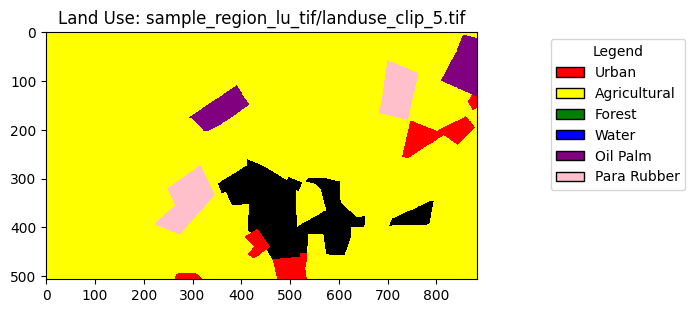

Processing sample_region_lu_tif/landuse_clip_1.tif
Raster CRS: EPSG:4326
Bounding Box: BoundingBox(left=102.28287652881372, bottom=16.570690705955556, right=102.29689041081313, top=16.57873667098176)


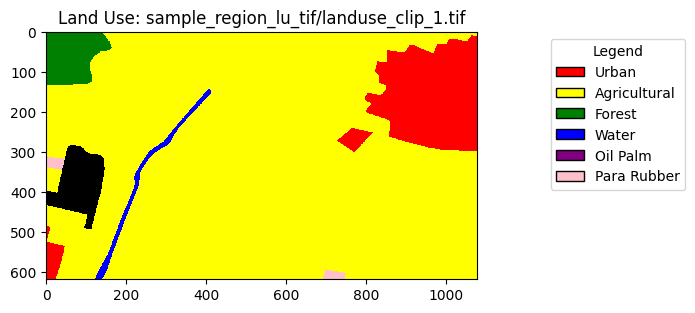

Processing sample_region_lu_tif/landuse_clip_3.tif
Raster CRS: EPSG:4326
Bounding Box: BoundingBox(left=102.37921871758711, bottom=16.587809503919217, right=102.3908666195087, top=16.594503642834393)


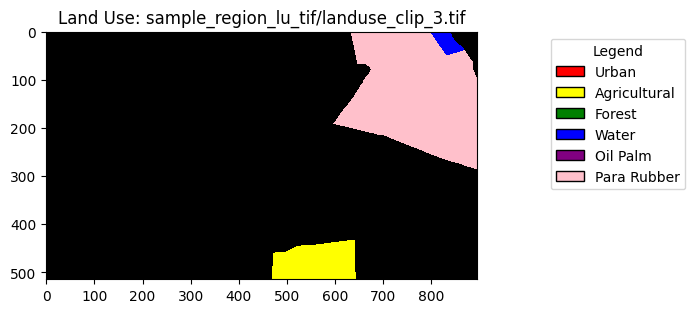

Processing sample_region_lu_tif/landuse_clip_2.tif
Raster CRS: EPSG:4326
Bounding Box: BoundingBox(left=102.37462975622738, bottom=16.532098670151367, right=102.3886436382268, top=16.54014463517757)


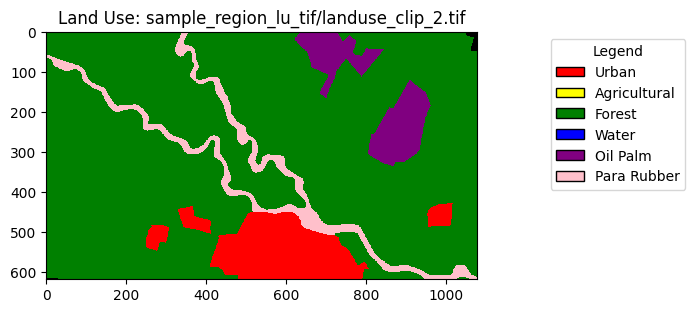

Processing sample_region_lu_tif/landuse_clip_4.tif
Raster CRS: EPSG:4326
Bounding Box: BoundingBox(left=102.41494241678416, bottom=16.53699903980384, right=102.42097436599356, top=16.540456595049346)


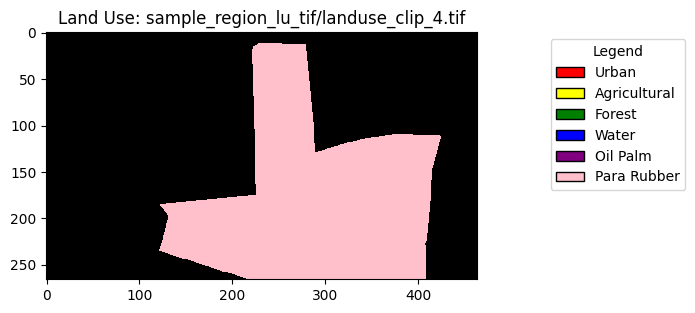

In [92]:
import glob
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import rasterio as rio
from rasterio.windows import from_bounds

# Suppress specific warning
warnings.filterwarnings("ignore", message="Attempting to set identical low and high")

# 対象のLand Use rasterを取得（例：landuse_*.tif）
landuse_rasters = glob.glob(os.path.join(sample_lu_dir, "landuse_*.tif"))

# colormapの定義
value_to_color = {
    1: 'red',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple',
    6: 'pink'
}

colors = [value_to_color.get(i, 'black') for i in range(0, max(value_to_color.keys()) + 1)]
cmap = ListedColormap(colors)

# 凡例の定義
lu_legend = {
    1: 'Urban',
    2: 'Agricultural',
    3: 'Forest',
    4: 'Water',
    5: 'Oil Palm',
    6: 'Para Rubber'
}

legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                   for value, color in value_to_color.items()]

# 各ランドユースラスタについて表示
for landuse_path in landuse_rasters:
    print(f"Processing {landuse_path}")

    with rio.open(landuse_path) as src:
        raster_data = src.read(1)
        crs = src.crs
        bounds = src.bounds  # (left, bottom, right, top)

    print("Raster CRS:", crs)
    print(f"Bounding Box: {bounds}")

    # 図の表示
    plt.figure(figsize=(8, 8))
    plt.imshow(raster_data, cmap=cmap, interpolation='none')
    plt.title(f"Land Use: {landuse_path}")

    # 凡例追加
    plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.tight_layout()
    plt.show()


### Stacking SPOT images and calculating spectral indices

This section processes SPOT images by:
- **Calculating spectral indices**:
  - **NDVI**: Measures vegetation health using the formula: `NDVI = (NIR - Red) / (NIR + Red)`.
  - **NDWI**: Detects water content using the formula: `NDWI = (Green - NIR) / (Green + NIR)`.
- **Multi-temporal stacking**: Combining SPOT images from 2022, 2020, and 2016, each with 6 bands (4 original + NDVI + NDWI), resulting in an 18-band composite image.

**Note**: This process may take up to 5 minutes depending on the image size and computational resources.

In [98]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds

def calculate_indices(image_path, window=None):
    with rasterio.open(image_path) as src:
        if window:
            blue = src.read(1, window=window).astype(float)
            green = src.read(2, window=window).astype(float)
            red = src.read(3, window=window).astype(float)
            nir = src.read(4, window=window).astype(float)
        else:
            blue = src.read(1).astype(float)
            green = src.read(2).astype(float)
            red = src.read(3).astype(float)
            nir = src.read(4).astype(float)
        meta = src.meta
    ndvi = (nir - red) / (nir + red)
    ndwi = (green - nir) / (green + nir)
    return ndvi, ndwi, meta

def process_and_stack_images(folder_path, output_dir):
    image_files = glob.glob(os.path.join(folder_path, "*.tif"))
    #image_files = [
        #os.path.join(folder_path, "img_SPOT2022A.tif"),
        # os.path.join(folder_path, "img_SPOT2020A.tif"),
        # os.path.join(folder_path, "img_SPOT2016A.tif")
    #]
    missing_files = [f for f in image_files if not os.path.exists(f)]
    if missing_files:
        raise FileNotFoundError(f"Missing images: {missing_files}")
        
    print(f"Processing images in order: {image_files}")

    os.makedirs(output_dir, exist_ok=True)

    for image_path in image_files:
        print(f"Processing {image_path}...")
        with rasterio.open(image_path) as src:
            bands = [src.read(i) for i in [3, 2, 1, 4]] 
            if any(np.any(band == src.nodata) for band in bands):
                raise ValueError(f"No-data values found in {image_path}")
            meta = src.meta

        ndvi, ndwi, _ = calculate_indices(image_path)

        all_bands = bands + [ndvi, ndwi]

        meta.update({
            'count': len(all_bands),
            'dtype': 'float32',
            'compress': 'Deflate'
        })

        # 出力ファイル名を作成（拡張子を _stacked.tif に変更）
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        output_file = os.path.join(output_dir, f"{base_name}_stacked.tif")

        print(f"Saving stacked image to {output_file}...")
        with rasterio.open(output_file, 'w', **meta) as dst:
            for idx, band in enumerate(all_bands, start=1):
                dst.write(band.astype(np.float32), idx)

    print("Done with calculating and stacking all images!")

In [99]:
%time
#stacked_spot_image =os.path.join(output_folder,"stack_6class.tif" ) # give file name to stack image
process_and_stack_images(sample_img_dir, output_folder) # , bbox

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.44 μs
Processing images in order: ['sample_region_tif/clip_4.tif', 'sample_region_tif/clip_2.tif', 'sample_region_tif/clip_1.tif', 'sample_region_tif/clip_5.tif', 'sample_region_tif/clip_3.tif']
Processing sample_region_tif/clip_4.tif...
Saving stacked image to Khon_Kaen_6class/clip_4_stacked.tif...
Processing sample_region_tif/clip_2.tif...
Saving stacked image to Khon_Kaen_6class/clip_2_stacked.tif...
Processing sample_region_tif/clip_1.tif...
Saving stacked image to Khon_Kaen_6class/clip_1_stacked.tif...
Processing sample_region_tif/clip_5.tif...
Saving stacked image to Khon_Kaen_6class/clip_5_stacked.tif...
Processing sample_region_tif/clip_3.tif...
Saving stacked image to Khon_Kaen_6class/clip_3_stacked.tif...
Done with calculating and stacking all images!


In [ ]:
## Visualizing the sample rasters
input_spot_path  =  "Khon_Kaen_6class/stack_6class.tif"

def visualize_raster(raster_path,name):
    with rio.open(raster_path) as src:
        data = src.read()
        print("\nImage shape:",data.shape) #check if the target images has 18bands

        # visualize the HLS file
        #rgb = src.read([3,2,1]) # change to [3,2,1] for RGB. [4,3,2] shows False Color
        rgb = src.read([1,2,3]) # change to [3,2,1] for RGB. [4,3,2] shows False Color

        # scale to 0-255 for visualization
        scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

        for i in range(3):
            band = rgb[i]
            min_val = np.min(band[band > 0]) #
            max_val = np.max(band[band > 0]) # band > 0 will select pixel values that are positive
            scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)

        scaled_rgb_new = scaled_rgb.transpose((1,2,0))

        # display the RGB image
        plt.figure(figsize=(8,8))
        plt.imshow(scaled_rgb_new)
        plt.title(name)
        plt.show()
        
# Visualize SPOT image
visualize_raster(input_spot_path,"SPOT_a_image")

In [100]:
# Importing required libraries for cropping and patch creation
import rasterio as rio
from rasterio.mask import mask
from rasterio.windows import Window
from shapely.geometry import box
import geopandas as gpd
import os
import numpy as np
from tqdm import tqdm

### Cropping SPOT imagery to land use extent
This section crops the stacked SPOT imagery to match the spatial extent of the Land use data, ensuring that the imagery covers only the relevant study area. The output is an 18-band image aligned with the Land use raster.

### Creating Image and Label Patches
This section generates 224x224 pixel patches from both the SPOT imagery and Land use raster, ensuring correspondence between image and label patches for training.

In [101]:
# Clipping imagery to a reference extent
def clip_to_reference_extent(source_path, reference_path, output_path):
    """Clip the source image to the extent of the reference image."""
    print(f"Clipping {os.path.basename(source_path)} to reference extent...")
    with rio.open(reference_path) as ref:
        ref_bounds = ref.bounds
        ref_bbox = box(ref_bounds.left, ref_bounds.bottom, ref_bounds.right, ref_bounds.top)
        ref_gdf = gpd.GeoDataFrame({'geometry': [ref_bbox]}, crs=ref.crs)
    
    with rio.open(source_path) as src:
        ref_gdf = ref_gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, ref_gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print("Clipping completed!")

In [175]:
# Creating random patches from SPOT and Land use data
def create_rm_patches(img_path, ann_path, img_output_dir, ann_output_dir, num_patches, patch_size=112, prefix="patch"):
    """Generate random patches from image and annotation rasters."""
    os.makedirs(img_output_dir, exist_ok=True)
    os.makedirs(ann_output_dir, exist_ok=True)
    
    with rio.open(img_path) as img, rio.open(ann_path) as ann:
        img_bands = img.count
        ann_bands = ann.count
        img_profile = img.profile
        ann_profile = ann.profile
        width, height = img.width, img.height

        for i in range(num_patches):
            x = np.random.randint(0, width - patch_size)
            y = np.random.randint(0, height - patch_size)
            print(img_path, ann_path , f"Patch {i+1} Coordinates: ({x}, {y})")

            window = Window(x, y, patch_size, patch_size)
            img_patch_data = img.read(window=window)
            ann_patch_data = ann.read(window=window)

            #img_output_path = os.path.join(img_output_dir, os.path.basename(img_path) +f'_{prefix}_tile-{x:03d}-{y:03d}.tif')
            #ann_output_path = os.path.join(ann_output_dir, os.path.basename(ann_path) + f'_{prefix}_tile-{x:03d}-{y:03d}.tif')
            img_output_path = os.path.join(img_output_dir, f'_{prefix}_tile-{x:03d}-{y:03d}.tif')
            ann_output_path = os.path.join(ann_output_dir, f'_{prefix}_tile-{x:03d}-{y:03d}.tif')
            img_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, img.transform)
            })
            ann_profile.update({
                'width': patch_size,
                'height': patch_size,
                'transform': rio.windows.transform(window, ann.transform)
            })

            with rio.open(img_output_path, 'w', **img_profile) as dst:
                dst.write(img_patch_data)
            with rio.open(ann_output_path, 'w', **ann_profile) as dst:
                dst.write(ann_patch_data)

In [184]:
# Processing images and creating patches
import os
import shutil

def process_images(landuse_path, spot_path, output_base_dir):
    """Clip Land Use to SPOT extent and create patches."""
    print("Starting image processing...")


    landuse_patches_dir = os.path.join(output_base_dir, 'landuse_patches_6class')
    spot_patches_dir = os.path.join(output_base_dir, 'spot_patches_6class')
    clipped_landuse_path = os.path.join(output_base_dir, 'clipped_landuse_6class')
    shutil.rmtree(landuse_patches_dir, ignore_errors=True)
    shutil.rmtree(spot_patches_dir, ignore_errors=True)
    
    lu_files = sorted(glob.glob(os.path.join(landuse_path, "*.tif")))
    img_files = sorted(glob.glob(os.path.join(spot_path, "*.tif")))

    for lu, img in zip(lu_files, img_files):
        # Clip Land Use to SPOT extent
        #clip_to_reference_extent(lu, img, clipped_landuse_path)
        # Create patches
        #create_rm_patches(spot_path, clipped_landuse_path, spot_patches_dir, landuse_patches_dir, 100)
        create_rm_patches(img, lu, spot_patches_dir, landuse_patches_dir, 50)
        print("Image processing completed successfully!")

In [185]:
# Executing image processing
import shutil

process_images(
    landuse_path=sample_lu_dir,
    spot_path=output_folder,
    output_base_dir=output_folder
)

Starting image processing...
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 1 Coordinates: (102, 435)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 2 Coordinates: (860, 270)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 3 Coordinates: (106, 71)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 4 Coordinates: (700, 20)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 5 Coordinates: (614, 121)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 6 Coordinates: (466, 214)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 7 Coordinates: (330, 458)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 8 Coordinates: (87, 372)
Khon_Kaen_6class/clip_1_stacked.tif sample_region_lu_tif/landuse_clip_1.tif Patch 9 Coordinates: (99, 359)
Kho

In [186]:
# Filtering patches to ensure correct dimensions
def filter_patch_images(image_folder):
    """Remove patches that do not match the desired size (224x224)."""
    desired_width, desired_height = 112, 112
    deleted_files = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
    
    for image_file in tqdm(image_files, desc="Processing Images", unit="image"):
        image_path = os.path.join(image_folder, image_file)
        try:
            with rio.open(image_path) as src:
                width, height = src.width, src.height
                if (width, height) != (desired_width, desired_height):
                    os.remove(image_path)
                    deleted_files.append(image_file)
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("\nSummary:")
    print(f"Total images processed: {len(image_files)}")
    print(f"Images deleted: {len(deleted_files)}")
    if deleted_files:
        print("Deleted files:")
        for file in deleted_files:
            print(f"- {file}")

# Filter SPOT and Land use patches
landuse_patch_folder = os.path.join(output_folder, 'landuse_patches_6class')
spot_patch_folder = os.path.join(output_folder, 'spot_patches_6class')
filter_patch_images(spot_patch_folder)
filter_patch_images(landuse_patch_folder)

Processing Images: 100%|██████████| 250/250 [00:00<00:00, 337.21image/s]



Summary:
Total images processed: 250
Images deleted: 0


Processing Images: 100%|██████████| 250/250 [00:00<00:00, 352.02image/s]


Summary:
Total images processed: 250
Images deleted: 0


### Splitting Data into Training, Validation, and Testing Sets

To support robust model development, the dataset is split into:
- **Training Set (70%)**: Used to train the model.
- **Validation Set (10%)**: Used to tune hyperparameters and monitor training performance.
- **Testing Set (20%)**: Used for final evaluation of the trained model on unseen data.

The split ensures that image and label patches remain paired across all sets.

In [187]:
# Splitting patches into training, validation, and testing sets
import os
import shutil
import random
import numpy as np
import re
pattern = r'clip_(\d+)_stacked\.tif'
replacement = r'landuse_clip_\1.tif'

def create_train_val_test_splits(
    image_dir, 
    mask_dir, 
    output_dir,
    train_ratio=0.70,
    val_ratio=0.20,
    test_ratio=0.10,
    random_seed=42
):
    """Split image and mask patches into training, validation, and testing sets."""
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Create directories for splits
    splits = ['train', 'val', 'test']
    for split in splits:
        for subdir in ['images', 'masks']:
            os.makedirs(os.path.join(output_dir, split, subdir), exist_ok=True)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    random.shuffle(image_files)
    
    total_size = len(image_files)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]
    
    def copy_files(file_list, split_name):
        print(f"Copying {split_name} files...")
        for filename in file_list:
            src_image = os.path.join(image_dir, filename)
            dst_image = os.path.join(output_dir, split_name, 'images', filename)
            shutil.copy2(src_image, dst_image)
            src_mask = os.path.join(mask_dir, re.sub(pattern, replacement, filename))
            dst_mask = os.path.join(output_dir, split_name, 'masks', re.sub(pattern, replacement, filename))
            shutil.copy2(src_mask, dst_mask)
    
    split_files = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }
    
    for split_name, files in split_files.items():
        copy_files(files, split_name)
        print(f"{split_name} split: {len(files)} images")

    return {
        'train_size': len(train_files),
        'val_size': len(val_files),
        'test_size': len(test_files)
    }

# Create final training data directory and perform splitting
final_training_data_folder = os.path.join(output_folder, 'final_training_data_6class')
shutil.rmtree(final_training_data_folder, ignore_errors=True)
os.makedirs(final_training_data_folder, exist_ok=True)

stats = create_train_val_test_splits(
    image_dir=spot_patch_folder,
    mask_dir=landuse_patch_folder,
    output_dir=final_training_data_folder,
    train_ratio=0.70,
    val_ratio=0.20,
    test_ratio=0.10,
    random_seed=42
)

print("\nData Split Summary:")
print(f"Total images: {sum(stats.values())}")
for split_name, size in stats.items():
    print(f"{split_name.capitalize()}: {size} images")

Copying train files...
train split: 175 images
Copying val files...
val split: 50 images
Copying test files...
test split: 25 images

Data Split Summary:
Total images: 250
Train_size: 175 images
Val_size: 50 images
Test_size: 25 images


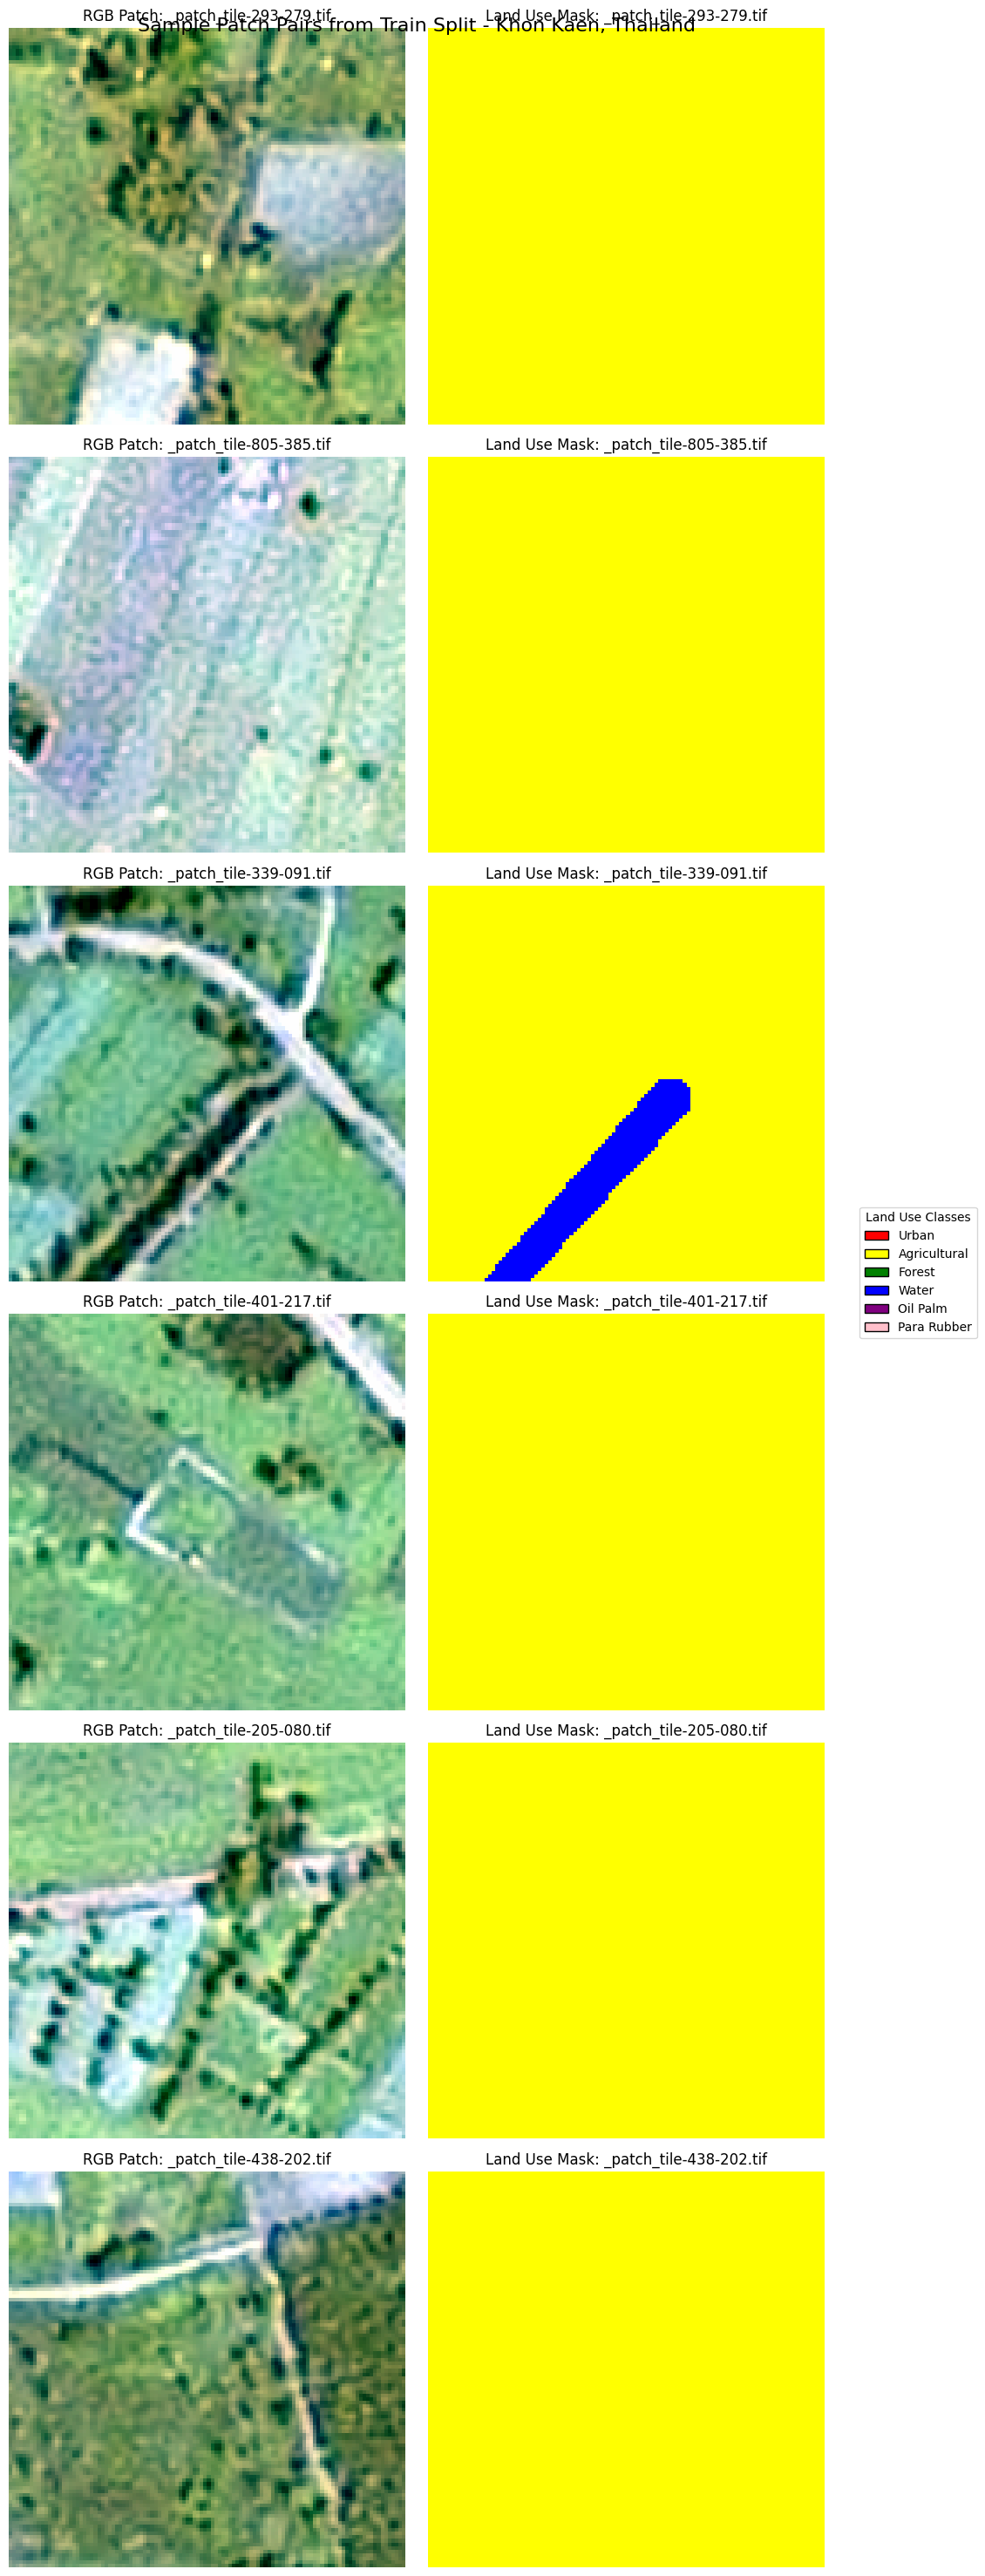

Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. Do the patches look consistent across splits? How do the Land Use classes vary in different patches?


In [188]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import random
import os

def visualize_sample_patches(output_dir, split='train', num_samples=6, random_seed=42):
    """
    Visualize a few sample image and mask patch pairs from a specified split.

    Parameters:
    - output_dir: Path to the final training data directory (e.g., 'final_training_data').
    - split: Split to visualize ('train', 'val', or 'test'). Default is 'train'.
    - num_samples: Number of patch pairs to display. Default is 3.
    - random_seed: Random seed for reproducibility. Default is 42.
    """
    # Validate inputs
    if split not in ['train', 'val', 'test']:
        raise ValueError(f"Invalid split: {split}. Choose 'train', 'val', or 'test'.")
    image_dir = os.path.join(output_dir, split, 'images')
    mask_dir = os.path.join(output_dir, split, 'masks')
    
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Image or mask directory not found in {output_dir}/{split}")

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    if len(image_files) < num_samples:
        raise ValueError(f"Requested {num_samples} samples, but only {len(image_files)} available in {split} split.")

    # Randomly select sample files
    random.seed(random_seed)
    sample_files = random.sample(image_files, num_samples)

    # Land Use class mapping and colors (from earlier notebook section)
    lu_classes = {
        1: 'Urban', 2: 'Agricultural', 3: 'Forest',
        4: 'Water', 5: 'Oil Palm', 6: 'Para Rubber'
    }
    lu_colors = {
        1: 'red', 2: 'yellow', 3: 'green',
        4: 'blue', 5: 'purple', 6: 'pink'
    }
    cmap = ListedColormap([lu_colors[i] for i in range(1, 7)])

    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for single sample

    for i, filename in enumerate(sample_files):
        # Read image patch
        image_path = os.path.join(image_dir, filename)
        with rasterio.open(image_path) as src:
            if src.count < 3:
                raise ValueError(f"Image {filename} has fewer than 3 bands.")
            blue = src.read(1).astype(float)  # Band 1: Blue
            green = src.read(2).astype(float)  # Band 2: Green
            red = src.read(3).astype(float)  # Band 3: Red
            nodata = src.nodata if src.nodata is not None else 0

        # Normalize RGB bands for display
        def normalize_band(band):
            band = np.where(band == nodata, np.nan, band)
            band = np.clip(band, 0, np.nanpercentile(band, 99))  # Clip outliers
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            return (band - band_min) / (band_max - band_min + 1e-10) if band_max > band_min else band

        red_norm = normalize_band(red)
        green_norm = normalize_band(green)
        blue_norm = normalize_band(blue)
        rgb = np.dstack((red_norm, green_norm, blue_norm))

        # Read mask patch
        mask_path = os.path.join(mask_dir, filename)
        with rasterio.open(mask_path) as src:
            if src.count != 1:
                raise ValueError(f"Mask {filename} should have 1 band, found {src.count}.")
            mask = src.read(1).astype(float)
            mask = np.where(mask == nodata, np.nan, mask)

        # Plot image and mask
        axes[i][0].imshow(rgb)
        axes[i][0].set_title(f"RGB Patch: {filename}")
        axes[i][0].axis('off')

        mask_im = axes[i][1].imshow(mask, cmap=cmap, vmin=1, vmax=6)
        axes[i][1].set_title(f"Land Use Mask: {filename}")
        axes[i][1].axis('off')

    # Add legend for Land Use classes
    legend_elements = [Patch(facecolor=lu_colors[i], edgecolor='black', label=lu_classes[i])
                       for i in range(1, 7)]
    fig.legend(handles=legend_elements, title="Land Use Classes", loc='center right',
               bbox_to_anchor=(1.15, 0.5))

    plt.suptitle(f"Sample Patch Pairs from {split.capitalize()} Split - Khon Kaen, Thailand", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Interactive Exercise for Training
    print("Interactive Exercise: Change the 'split' parameter to 'val' or 'test' and re-run the visualization. "
          "Do the patches look consistent across splits? How do the Land Use classes vary in different patches?")

# Visualize 3 sample patch pairs from the train split
final_training_data_folder = os.path.join(output_folder, 'final_training_data_6class')
visualize_sample_patches(final_training_data_folder, split='train', num_samples=6, random_seed=42)

### 3.2 MODEL FINETUNING FOR 6-CLASS LAND USE CLASSIFICATION OF SPOT IMAGES

### 3.2.1 Prerequisites
To successfully complete this module, learners should have:
- A basic understanding of remote sensing and deep learning concepts (e.g., neural networks, loss functions).
- Familiarity with Python and libraries like `MMSegmentation`.
- A Python environment with required libraries installed and access to a GPU for training.

### 3.2.2 Required Inputs
- **Stacked SPOT Image**: A multi-band GeoTIFF (`stack_6class.tif`) with 18 bands (6 bands × 3 years).
- **Training, Validation, and Test Datasets**: Image and mask patch pairs in `final_training_data_6class/train`, `final_training_data_6class/val`, and `final_training_data_6class/test` directories, generated from the previous notebook.
- **Pretrained Model Weights**: Prithvi-100M weights located at `/prithvi/Prithvi_100M.pt`.es."
   ]IoU.

In [189]:
%%writefile finetuning_config_spot_6class.py

import warnings

warnings.filterwarnings(
    "ignore",
    message="We have added an arg 'border_mode' in this func"
)

import os, rasterio

experiment = 'exp01_6class' #"<experiment name>"
data_root = 'Khon_Kaen_6class/final_training_data_6class' #<path to data root>
project_dir = 'spot_a_training_6class' #"<project directory name>"
work_dir = os.path.join(project_dir, experiment)
save_path = work_dir
img_stack = 'Khon_Kaen_6class/clip_1_stacked.tif' #'Khon_Kaen/stack_6class.tif'

dist_params = dict(backend="nccl")
log_level = "INFO"
load_from = None
resume_from = None
cudnn_benchmark = True
custom_imports = dict(imports=["geospatial_fm"])
# import geofm
num_frames = 1
img_size = 112 #224 #size of the patch images used in training (224x224)
num_workers = 1 #original is 4, this is an overall parameter used to define the 


### MODEL PARAMETERS TO BE DEFINED BY USER
#pretrained_weights_path = "/prithvi/Prithvi_100M.pt" #"<path to pretrained weights>"
pretrained_weights_path = "/home/jovyan/prithvi/Prithvi_100M.pt"
num_layers = 12
patch_size = 16 #original is 16
patch_grid = img_size // patch_size
embed_dim = 768
num_heads = 12
tubelet_size = 1
max_epochs = 100
eval_epoch_interval = 1


loss_weights_multi = [ #0.0,
                      1.0,
                      1.0,
                      1.0,
                      1.0,
                      1.0,
                      1.0]
# Define the land-use or land-cover classes 
CLASSES = (
            #'NAN', #NAN
            "URB", #urban
            "AGR", #agricultural
            "FOR", #forest
            "WTR", #water
            "OIL", #oil palm
            "PRB") #para rubber


loss_func = dict(
    type="FocalLoss",
    gamma=2.0,  # Focuses more on difficult-to-learn classes like PRB
    alpha=loss_weights_multi,  # Still keeps class weight balancing
#    type="CrossEntropyLoss",
#    use_sigmoid=False,
#    class_weight=loss_weights_multi,
#    avg_non_ignore=True,
)

output_embed_dim = embed_dim * num_frames



dataset_type = "GeospatialDataset"

## The 18 values for 'means and stds lists' are specific for Thailand, these can be modified if the model is applied to a different region.


img_norm_cfg = dict(
    means=rasterio.open(img_stack).read().mean(axis=(1,2)).tolist(),
    stds=rasterio.open(img_stack).read().std(axis=(1,2)).tolist(),
)
          
bands = [1, 2, 3, 4, 5, 6]

tile_size = 112 #224
orig_nsize = 512
crop_size = (tile_size, tile_size)
train_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="LoadGeospatialAnnotations", reduce_zero_label=True),
    dict(type="RandomFlip",  prob=0.5),
    dict(type="RandomRotate", prob=0.5, degree=10),
    #dict(type="Resize", img_scale=(512, 512), ratio_range=(0.8, 1.2)),
    #dict(type="RandomCrop", crop_size=crop_size, cat_max_ratio=0.75),
    dict(type="ToTensor", keys=["img", "gt_semantic_seg"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="TorchRandomCrop", crop_size=crop_size),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, tile_size, tile_size),
    ),
    dict(type="Reshape", keys=["gt_semantic_seg"], new_shape=(1, tile_size, tile_size)),
    dict(type="CastTensor", keys=["gt_semantic_seg"], new_type="torch.LongTensor"),
    dict(type="Collect", keys=["img", "gt_semantic_seg"]),
]

test_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="ToTensor", keys=["img"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, -1, -1),
        look_up=dict({"2": 1, "3": 2}),
    ),
    dict(type="CastTensor", keys=["img"], new_type="torch.FloatTensor"),
    dict(
        type="CollectTestList",
        keys=["img"],
        meta_keys=[
            "img_info",
            "seg_fields",
            "img_prefix",
            "seg_prefix",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ],
    ),
]


dataset = "GeospatialDataset"
data = dict(
    samples_per_gpu=1, #original is 8, decrease this parameter if the memory consumption is too much
    workers_per_gpu=1, #original is 2, decrease this parameter if the memory consumption is too much
    train=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='train/images',
        ann_dir='train/masks',
        pipeline=train_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    val=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='val/images',
        ann_dir='val/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    test=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='test/images',
        ann_dir='test/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
)

optimizer = dict(type="AdamW", lr=1e-6, betas=(0.9, 0.999), weight_decay=0.05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy="poly",
    warmup="linear",
    warmup_iters=500,
    warmup_ratio=1e-06,
    power=1.0,
    min_lr=0.0,
    by_epoch=False,
)

log_config = dict(
    interval=10, hooks=[dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook")]
)

checkpoint_config = dict(by_epoch=True, interval=5, out_dir=save_path)

evaluation = dict(
    interval=eval_epoch_interval,
    metric="mIoU",
    pre_eval=True,
    save_best="mIoU",
    by_epoch=True,
)
reduce_train_set = dict(reduce_train_set=False)
reduce_factor = dict(reduce_factor=1)
runner = dict(type="EpochBasedRunner", max_epochs=max_epochs)
workflow = [("train", 1)]
norm_cfg = dict(type="BN", requires_grad=True)

model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=12, 
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=embed_dim * num_frames,
        output_embed_dim=output_embed_dim,
        drop_cls_token=True,
        Hp=7, #14,
        Wp=7, #14,
    ),
    decode_head=dict(
        num_classes=6, #len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    auxiliary_head=dict(
        num_classes=6, # len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=2,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    train_cfg=dict(),
    test_cfg=dict(
        mode="slide",
        stride=(int(tile_size / 2), int(tile_size / 2)),
        crop_size=(tile_size, tile_size),
    ),
)

auto_resume = False

Overwriting finetuning_config_spot_6class.py


In [114]:
!mim train mmsegmentation finetuning_config_spot_6class.py

The codebase mmsegmentation is not installed, do you want to install the latest release?  [y/N]: ^C
Aborted!


## 3.3 USING FINETUNE 6-CLASS PRITHVI MODEL FOR INFERENCE

For our specific use case, Inferencing is the part where we use the finetuned Prithvi model to predict land use classes based on the 6 classes we used for training. To recap, the 6 classes that we have are:

| Land Use | Raster Value | Color Code |
|----------|----|----|
| Urban | 1 | red |
| Agricultural | 2 | yellow |
| Forest | 3 | green |
| Water | 4 | blue |
| Oil Palm | 5 | purple |
| Para Rubber | 6 | pink |",nce."ge."

In [ ]:
%%time
# Visualizing Bangkok and Ubon-Ratchathani
# ESTIMATED RUNTIME: <1 minute, if the cell runs for more than 1min, restart the kernel

import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the sample rasters
spot_path  =  "Khon-kaen-6class/stack_6class.tif"

def visualize_raster(raster_path,name):
    with rio.open(raster_path) as src:
        data = src.read()
        print("\nImage shape:",data.shape) #check if the target images has 18bands

        # visualize the HLS file
        rgb = src.read([1,2,3]) # change to [3,2,1] for RGB. [4,3,2] shows False Color

        # scale to 0-255 for visualization
        scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

        for i in range(3):
            band = rgb[i]
            min_val = np.min(band[band > 0]) #
            max_val = np.max(band[band > 0]) # band > 0 will select pixel values that are positive
            scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)

        scaled_rgb_new = scaled_rgb.transpose((1,2,0))

        # display the RGB image
        plt.figure(figsize=(8,8))
        plt.imshow(scaled_rgb_new)
        plt.title(name)
        plt.show()
        
# Visualize SPOT image
visualize_raster(spot_path,"SPOT_image")

#### Inference land use of SPOT image
This is the core step of the inference process. It involves loading your saved model and feeding it the prepared SPOT image data.

**Running the actual inferencing**

IMPORTANT: Due to a relatively long code, the succeeding cells should be executed/run in sequence as we run the inference cell by cell.

In [ ]:
%%time
# ESTIMATED RUNTIME: <1 minute

import os
import glob
import time

import numpy as np
import rasterio
import torch
from mmcv import Config
from mmcv.parallel import collate, scatter
from mmseg.apis import init_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile

## DEFINE PARAMETERS, change the paths as necessary
config_path = 'finetuning_config_spot.py'
ckpt = 'spot_a_training/exp01/best_mIoU_epoch_41.pth' ###### TO SPECIFY THE MODEL FILE *.pth ######
input_path = 'target_datasets_cropped' # path to input images folder for inference
input_type = 'tif' #file type of input images
output_path = 'output/inference_outputs' #path to save output image
bands = None # bands in the file where to find the relevant data, type = int. Use only if there are specific bands in the target dataset where the data is
device = 'cuda' #default value is cuda, change accordingly

## ACTUAL INFERENCE
#### STEP 1: load the model
print("\n>>> Step 1: Loading the model <<<")
config = Config.fromfile(config_path)
config.model.backbone.pretrained = None
model = init_segmentor(config, ckpt, device)

#### STEP 2: locate the target images
print("\n>>> Step 2: Locate the target images <<<")
target_images = glob.glob(os.path.join(input_path, "*." + input_type))
print("No of target images:",len(target_images))

# check if output folder available
if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
#### STEP 3: Test Pipeline
#NOTE:THIS IS ONLY FOR IMAGES THAT HAVE SPECIFIC TARGET BANDS
print("\n>>> Step 3: Modify the test pipeline if necessary <<<")

def process_test_pipeline(custom_test_pipeline, bands=None):
    # change extracted bands if necessary
    if bands is not None:
        extract_index = [
            i for i, x in enumerate(custom_test_pipeline) if x["type"] == "BandsExtract"
        ]

        if len(extract_index) > 0:
            custom_test_pipeline[extract_index[0]]["bands"] = bands

    collect_index = [
        i for i, x in enumerate(custom_test_pipeline) if x["type"].find("Collect") > -1
    ]

    # adapt collected keys if necessary
    if len(collect_index) > 0:
        keys = [
            "img_info",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ]
        custom_test_pipeline[collect_index[0]]["meta_keys"] = keys

    return custom_test_pipeline

# run the function
custom_test_pipeline = process_test_pipeline(model.cfg.data.test.pipeline, bands)

In [ ]:
%%time
# ESTIMATED RUNTIME: 6 - 15 minutes
# Some parts of the code are from the model_inference.py script available from the Prithvi github
# IMPORTANT: The larger the image for prediction, the more memory and CPU utilization is expected. Runtime also takes a lot longer

#### STEP 4: Iterate prediction for every output image
print("\n>>> Step 4: Iterate prediction for every output image <<<")

# define a function to open/read a tif file
def open_tiff(fname):
    with rasterio.open(fname, "r") as src:
        data = src.read()

    return data

# define a function to write a tif file
def write_tiff(img_wrt, filename, metadata):
    """
    It writes a raster image to file.

    :img_wrt: numpy array containing the data (can be 2D for single band or 3D for multiple bands)
    :filename: file path to the output file
    :metadata: metadata to use to write the raster to disk
    :return:
    """

    with rasterio.open(filename, "w", **metadata) as dest:
        if len(img_wrt.shape) == 2:
            img_wrt = img_wrt[None]

        for i in range(img_wrt.shape[0]):
            dest.write(img_wrt[i, :, :], i + 1)

    return filename

# define a function get the metadata of an image
def get_meta(fname):
    with rasterio.open(fname, "r") as src:
        meta = src.meta

    return meta

# define function to perform inference
def inference_segmentor(model, imgs, custom_test_pipeline=None):
    """Inference image(s) with the segmentor.

    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = (
        [LoadImageFromFile()] + cfg.data.test.pipeline[1:]
        if custom_test_pipeline == None
        else custom_test_pipeline
    )
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = []
    imgs = imgs if isinstance(imgs, list) else [imgs]
    for img in imgs:
        img_data = {"img_info": {"filename": img}}
        img_data = test_pipeline(img_data)
        data.append(img_data)
    # print(data.shape)

    data = collate(data, samples_per_gpu=len(imgs))
    if next(model.parameters()).is_cuda:
        # data = collate(data, samples_per_gpu=len(imgs))
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        # img_metas = scatter(data['img_metas'],'cpu')
        # data['img_metas'] = [i.data[0] for i in data['img_metas']]

        img_metas = data["img_metas"].data[0]
        img = data["img"]
        data = {"img": img, "img_metas": img_metas}

    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

# define function to perform inference on each target file
def inference_on_file(model, target_image, output_image, custom_test_pipeline):
    time_taken = -1
    try:
        st = time.time()
        print("Running inference...")
        result = inference_segmentor(model, target_image, custom_test_pipeline)
        print("Output has shape: " + str(result[0].shape))

        # get metadata mask
        mask = open_tiff(target_image)
        meta = get_meta(target_image)
        mask = np.where(mask == meta["nodata"], 1, 0)
        mask = np.max(mask, axis=0)[None]

        result[0] = np.where(mask == 1, -1, result[0])

        # sve file to disk
        meta["count"] = 1
        meta["dtype"] = "int16"
        meta["compress"] = "lzw"
        meta["nodata"] = -1
        print("Saving output...")
        write_tiff(result[0], output_image, meta)
        et = time.time()
        time_taken = np.round(et - st, 1)
        print(
            f"Inference completed in {str(time_taken)} seconds. Output available at: "
            + output_image
        )

    except:
        print(f"Error on image {target_image} \nContinue to next input")

    return time_taken

# for each image predict and save to disk
for i, target_image in enumerate(target_images):
    print("\n> Working on Image {} <".format(i+1))
    output_image = os.path.join(
        output_path,
        target_image.split("/")[-1].replace(
            "." + input_type, "_pred." + input_type
        ),
    )
    
    inference_on_file(model,
                      target_image,
                      output_image,
                      custom_test_pipeline)

#### Visualize inference output
Visualizing the output is crucial for understanding your model's performance and identifying any misclassifications or patterns. The inferred land use map will be a raster where each pixel is assigned a predicted land use class ID. You'll use a colormap to represent these different classes visually, making the map interpretable.

In [ ]:
%%time
## Visualizing outputs for Bangkok and Ubon-Ratchathani
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Step 1: read the raster file
# IMPORTANT: Make sure that the paths contain the output inference images
outpath  = "output/inference_outputs/stack_pred_6class.tif"

def visualize_lu_raster(raster_path,region):
    # Step 1: read the file
    with rio.open(raster_path) as src:
        raster_data = src.read(1) #read just the 1st band
        crs = src.crs

    print("Raster CRS:",crs) #check the coordinate reference system of the raster file

    # Step 2: define the colormap
    # Colors are assigned based on value / Landuse type
    value_to_color = {
        1:'red',
        2:'yellow',
        3:'green',
        4:'blue',
        5:'purple',
        6:'pink'}

    # create a colormap with these values
    colors = [value_to_color.get(i,'black') for i in range(0,max(value_to_color.keys()) + 1)]
    cmap = ListedColormap(colors)

    # Step 3: Display the raster with the colormap
    plt.figure(figsize=(8,8))
    plt.title(f"{region} Use Map")
    plt.imshow(raster_data,cmap=cmap,interpolation='none')

    # Step 4: Add legend
    # define the raster value and corresponding land use type
    lu_legend = {1:'Urban',
                 2:'Agricultural',
                 3:'Forest',
                 4:'Water',
                 5:'Oil Palm',
                 6:'Para Rubber'}

    legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                       for value, color in value_to_color.items()]
    plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.3, 1))

    # show the plot
    plt.tight_layout()
    plt.show()
    
visualize_lu_raster(outpath,"Region A")

# SECTION 4. INFERENCE OF LAND USE CLASSES FOR A NEARBY REGION WITH INACCURATE LU POLYGON

This section applies the fine-tuned Prithvi model (6-class configuration) to a nearby region in Thailand with an inaccurate land use (LU) polygon. The goal is to predict land use classes and identify inconsistencies between the model’s predictions and the provided LU layer, highlighting areas where the LU data may be outdated or incorrect.

## 4.1 Inference and browsing outputs

**Objectives**:
- Apply the 6-class fine-tuned model to a new region’s SPOT imagery.
- Visualize the predicted land use map and compare it with the inaccurate LU layer.
- Highlight areas of inconsistency between the predicted and LU classes.

**Required inputs**:
- Fine-tuned model checkpoint (`spot_a_training/exp01/best_mIoU_epoch_41.pth`).
- Configuration file (`finetuning_config_spot.py`).
- Stacked SPOT image for the nearby region (e.g., `nearby_region/stack_nearby.tif`).
- Inaccurate LU shapefile for the nearby region (e.g., `nearby_region/gt_LU2022B_inaccurate.shp`).

**Notes**:
- The nearby region’s SPOT image should have the same 18-band structure (6 bands × 3 time steps) as the training data.
- The LU shapefile is assumed to have the same 6 classes (Urban, Agricultural, Forest, Water, Oil Palm, Para Rubber) but contains inaccuracies.
- Ensure the SPOT image and LU shapefile are in the same CRS to avoid misalignment.

In [ ]:
%%time
import os
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mmcv import Config
from mmseg.apis import init_segmentor, inference_segmentor
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.windows import from_bounds

# Define paths
config_path = 'finetuning_config_spot.py'
ckpt = 'spot_a_training/exp01/best_mIoU_epoch_41.pth'
input_path = 'nearby_region/stack_nearby.tif'  # Path to nearby region's SPOT image
lu_shp_path = 'nearby_region/gt_LU2022B_inaccurate.shp'  # Path to inaccurate LU shapefile
output_path = 'output/inference_outputs/stack_nearby_pred.tif'
lu_raster_path = 'output/inference_outputs/lu_nearby_raster.tif'

# Step 1: Rasterize the inaccurate LU shapefile
def rasterize_lu_shapefile(shp_path, ref_img_path, output_path):
    with rio.open(ref_img_path) as ref:
        meta = ref.meta.copy()
        transform = ref.transform
        width, height = ref.width, ref.height
        crs = ref.crs
    
    gdf = gpd.read_file(shp_path)
    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)
    
    # Map LU classes to raster values
    lu_code_map = {'URB': 1, 'AGR': 2, 'FOR': 3, 'WTR': 4, 'OIL': 5, 'PRB': 6}
    gdf['lu_code'] = gdf['LUL1_CODE'].map(lu_code_map)
    
    meta.update({'count': 1, 'dtype': 'int16', 'nodata': -1, 'compress': 'lzw'})
    with rio.open(output_path, 'w', **meta) as dst:
        rasterized = rasterize(
            ((geom, value) for geom, value in zip(gdf.geometry, gdf['lu_code'])),
            out_shape=(height, width),
            transform=transform,
            fill=-1,
            dtype='int16'
        )
        dst.write(rasterized, 1)
    print(f"Rasterized LU saved to: {output_path}")

# Step 2: Run inference
def run_inference(config_path, ckpt, input_path, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    config = Config.fromfile(config_path)
    config.model.backbone.pretrained = None
    model = init_segmentor(config, ckpt, device='cuda')
    
    with rio.open(input_path) as src:
        meta = src.meta.copy()
        meta.update({'count': 1, 'dtype': 'int16', 'nodata': -1, 'compress': 'lzw'})
    
    result = inference_segmentor(model, input_path)[0]
    with rio.open(output_path, 'w', **meta) as dst:
        dst.write(result, 1)
    print(f"Inference output saved to: {output_path}")

# Step 3: Visualize predictions and LU layer
def visualize_comparison(pred_path, lu_path, region_name):
    with rio.open(pred_path) as pred_src:
        pred_data = pred_src.read(1)
    with rio.open(lu_path) as lu_src:
        lu_data = lu_src.read(1)
    
    # Compute inconsistencies
    inconsistencies = (pred_data != lu_data) & (pred_data != -1) & (lu_data != -1)
    
    # Define colormap
    value_to_color = {1: 'red', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple', 6: 'pink'}
    lu_legend = {1: 'Urban', 2: 'Agricultural', 3: 'Forest', 4: 'Water', 5: 'Oil Palm', 6: 'Para Rubber'}
    colors = [value_to_color.get(i, 'black') for i in range(0, 7)]
    cmap = ListedColormap(colors)
    
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(pred_data, cmap=cmap, interpolation='none')
    ax1.set_title(f'Predicted Land Use - {region_name}')
    ax1.axis('off')
    
    ax2.imshow(lu_data, cmap=cmap, interpolation='none')
    ax2.set_title(f'Inaccurate LU Layer - {region_name}')
    ax2.axis('off')
    
    ax3.imshow(inconsistencies, cmap='YlOrRd', interpolation='none')
    ax3.set_title('Inconsistent Areas')
    ax3.axis('off')
    
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                       for value, color in value_to_color.items()]
    fig.legend(handles=legend_elements, title="Land Use Classes", loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.tight_layout()
    plt.show()

# Execute steps
rasterize_lu_shapefile(lu_shp_path, input_path, lu_raster_path)
run_inference(config_path, ckpt, input_path, output_path)
visualize_comparison(output_path, lu_raster_path, "Nearby Region")

## 4.2 Overlay (Intersect Analysis) of Inference Result and LU Layer

This section performs an overlay analysis to extract areas where the predicted land use classes differ from the inaccurate LU layer. The result is a vector layer (shapefile) containing polygons of inconsistent areas, which can be used to quantify and analyze discrepancies.

**Objectives**:
- Identify and extract polygons where the predicted and LU classes differ.
- Save the inconsistent areas as a shapefile for further analysis.
- Provide statistics on the extent of inconsistencies (e.g., area per class).

**Required Inputs**:
- Predicted land use raster (`output/inference_outputs/stack_nearby_pred.tif`).
- Rasterized inaccurate LU layer (`output/inference_outputs/lu_nearby_raster.tif`).
- Original LU shapefile (`nearby_region/gt_LU2022B_inaccurate.shp`) for reference.

In [ ]:
%%time
import rasterio as rio
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from rasterio.features import shapes
import rioxarray
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def extract_inconsistent_polygons(pred_path, lu_raster_path, output_shp_path):
    """
    Identify inconsistent areas between prediction and land use rasters, with value remapping for land use raster.
    """
    # Open prediction raster
    with rio.open(pred_path) as pred_src:
        pred_data = pred_src.read(1)
        transform = pred_src.transform
        crs = pred_src.crs
        pred_profile = pred_src.profile

    # Open and preprocess land use raster
    with rio.open(lu_raster_path) as lu_src:
        lu_data = lu_src.read(1)
        lu_transform = lu_src.transform
        lu_crs = lu_src.crs

        # Remove value 0 (treat as no-data) and remap 1-6 to 0-5
        print("Remapping land use raster values: 0 -> no-data, 1-6 -> 0-5")
        lu_data_mapped = np.where(lu_data == 0, -1, lu_data - 1)  # Set 0 to -1 (no-data), subtract 1 from others

        # Align land use raster to prediction raster if CRS or shape differs
        if lu_crs != crs or lu_data.shape != pred_data.shape:
            print("Aligning land use raster to prediction raster...")
            lu_data_aligned = np.empty_like(pred_data, dtype=lu_data_mapped.dtype)
            reproject(
                source=lu_data_mapped,
                destination=lu_data_aligned,
                src_transform=lu_transform,
                src_crs=lu_crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.nearest
            )
        else:
            lu_data_aligned = lu_data_mapped

    # Mask no-data values
    mask = (pred_data != -1) & (lu_data_aligned != -1)
    inconsistencies = (pred_data != lu_data_aligned) & mask
    
    # Convert inconsistent areas to polygons
    shapes_gen = shapes(inconsistencies.astype(np.int16), mask=mask, transform=transform)
    geometries = []
    values = []
    for geom, value in shapes_gen:
        if value == 1:  # Inconsistent areas
            geometries.append(shape(geom))
            values.append(1)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': geometries, 'inconsistent': values}, crs=crs)
    
    # Add predicted and LU classes (updated mapping for 0-5)
    pred_classes = []
    lu_classes = []
    lu_class_map = {0: 'URB', 1: 'AGR', 2: 'FOR', 3: 'WTR', 4: 'OIL', 5: 'PRB'}
    for geom in gdf.geometry:
        centroid = geom.centroid
        row, col = rio.transform.rowcol(transform, centroid.x, centroid.y)
        if 0 <= row < pred_data.shape[0] and 0 <= col < pred_data.shape[1]:
            pred_val = pred_data[row, col]
            lu_val = lu_data_aligned[row, col]
            pred_classes.append(lu_class_map.get(pred_val, 'Unknown'))
            lu_classes.append(lu_class_map.get(lu_val, 'Unknown'))
        else:
            pred_classes.append('Unknown')
            lu_classes.append('Unknown')
    
    gdf['pred_class'] = pred_classes
    gdf['lu_class'] = lu_classes
    
    # Save to shapefile
    gdf.to_file(output_shp_path)
    print(f"Inconsistent areas saved to: {output_shp_path}")
    
    # Compute statistics
    print("\nStatistics of Inconsistent Areas:")
    print(gdf.groupby(['pred_class', 'lu_class']).size().reset_index(name='count'))
    print(f"Total inconsistent polygons: {len(gdf)}")
    print(f"Total inconsistent area: {gdf.geometry.area.sum() / 1e4:.2f} hectares")

    return gdf

def visualize_inconsistent_areas(shp_path, color_by='pred_class'):
    """
    Visualize inconsistent areas from a shapefile with a legend.

    Parameters:
    - shp_path: Path to the shapefile containing inconsistent areas.
    - color_by: Column to color polygons by ('pred_class' or 'lu_class'). Default is 'pred_class'.
    """
    # Read the shapefile
    gdf = gpd.read_file(shp_path)
    if gdf.empty:
        raise ValueError("Shapefile is empty or invalid.")

    # Define class colors
    class_colors = {
        'URB': 'red',        # Urban
        'AGR': 'green',      # Agriculture
        'FOR': 'darkgreen',  # Forest
        'WTR': 'blue',       # Water
        'OIL': 'yellow',     # Oil
        'PRB': 'purple',     # Problematic
        'Unknown': 'gray'
    }

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot shapefile, collecting non-empty classes for legend
    legend_elements = []
    for class_name, color in class_colors.items():
        class_gdf = gdf[gdf[color_by] == class_name]
        if not class_gdf.empty:
            class_gdf.plot(ax=ax, color=color, alpha=0.6)
            legend_elements.append(Patch(facecolor=color, edgecolor='black', label=f'{color_by}: {class_name}', alpha=0.6))

    ax.set_title(f"Inconsistent Areas (Colored by {color_by})", fontsize=14)
    if legend_elements:
        ax.legend(handles=legend_elements)
    else:
        print("Warning: No valid classes found for legend.")
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary of Inconsistent Areas:")
    print(gdf.groupby(['pred_class', 'lu_class']).size().reset_index(name='count'))
    print(f"Total inconsistent polygons: {len(gdf)}")
    print(f"Total inconsistent area: {gdf.geometry.area.sum() / 1e4:.2f} hectares")

    # Interactive Exercise
    print("\nInteractive Exercise: Change the 'color_by' parameter to 'lu_class' and re-run the visualization. "
          "What patterns do you observe in the spatial distribution of inconsistencies (e.g., are certain class transitions like URB→AGR more common in specific areas)?")
# Define paths
pred_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/stack_pred_6class.tif'
lu_raster_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/clipped_landuse_6class.tif'
output_shp_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/inconsistent_areas.shp'

# Execute overlay analysis and get GeoDataFrame
gdf = extract_inconsistent_polygons(pred_path, lu_raster_path, output_shp_path)

# Visualize the shapefile
visualize_inconsistent_areas(output_shp_path, color_by='pred_class')

### 4.3 (Optional) Aggregate inconsistent areas by grids

This optional section aggregates the inconsistent areas into a grid to visualize the spatial distribution of discrepancies, reducing the visual impact of noisy or minor differences. The grid-based aggregation summarizes the total inconsistent area within each grid cell, making it easier to identify regions with significant LU inaccuracies.

**Objectives**:
- Create a regular grid over the study area.
- Aggregate inconsistent polygons by grid cells, calculating the total inconsistent area per cell.
- Visualize the grid-based distribution using a heatmap.

**Required Inputs**:
- Inconsistent areas shapefile (`output/inference_outputs/inconsistent_areas.shp`).
- Reference SPOT image (`nearby_region/stack_nearby.tif`) to define the grid extent.

In [ ]:
%%time
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Define paths
inconsistent_shp_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/inconsistent_areas.shp'
ref_img_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/stack_6class.tif'
output_grid_shp_path = '/home/jovyan/shared/Dan/THA Space-AI training materials/Experiment_SPOT/learning_notebooks/Khon_Kaen_6class/overlay_analysis/inconsistent_grid.shp'

# Step 1: Create grid
def create_grid(ref_img_path, grid_size=30):  # Grid size in meters
    with rio.open(ref_img_path) as src:
        bounds = src.bounds
        crs = src.crs
    
    minx, miny, maxx, maxy = bounds
    if not all(np.isfinite([minx, miny, maxx, maxy])):
        raise ValueError("Raster bounds are invalid or non-finite.")
    
    # Adjust grid_size for geographic CRS (degrees)
    if crs.is_geographic:
        # Use mean latitude for conversion (1° ≈ 111,000 m, adjusted by cos(latitude))
        mean_lat = (miny + maxy) / 2
        meters_per_degree = 111000 * np.cos(np.radians(mean_lat))
        grid_size_deg = grid_size / meters_per_degree
        print(f"CRS is geographic. Converting grid_size from {grid_size} meters to {grid_size_deg:.6f} degrees at latitude {mean_lat:.2f}°.")
    else:
        grid_size_deg = grid_size  # Assume grid_size is in CRS units (meters)
    
    # Calculate extent
    extent_width = maxx - minx
    extent_height = maxy - miny
    
    # Check if grid_size is too large
    x_points = int(np.ceil(extent_width / grid_size_deg))
    y_points = int(np.ceil(extent_height / grid_size_deg))
    if x_points < 2 or y_points < 2:
        suggested_size = min(extent_width, extent_height) * (111000 if crs.is_geographic else 1) / 10
        print(f"Extent (width, height): ({extent_width}, {extent_height})")
        print(f"Grid size: {grid_size_deg} {'degrees' if crs.is_geographic else 'meters'}")
        print(f"Suggested grid_size: {suggested_size:.2f} {'meters' if not crs.is_geographic else 'meters (≈ ' + str(suggested_size / meters_per_degree) + ' degrees)'}")
        raise ValueError("Grid size too large or raster extent too small to create grid. Try a smaller grid_size.")
    
    x = np.arange(minx, maxx, grid_size_deg)
    y = np.arange(miny, maxy, grid_size_deg)
    
    grids = []
    for i in range(len(x) - 1):
        for j in range(len(y) - 1):
            grids.append(box(x[i], y[j], x[i+1], y[j+1]))
    
    grid_gdf = gpd.GeoDataFrame({'geometry': grids}, crs=crs)
    print(f"Created grid with {len(grid_gdf)} cells.")
    return grid_gdf

# Step 2: Aggregate inconsistent areas by grid
def aggregate_by_grid(inconsistent_shp_path, grid_gdf, output_path):
    inconsistent_gdf = gpd.read_file(inconsistent_shp_path)
    if inconsistent_gdf.empty:
        raise ValueError("Inconsistent areas shapefile is empty.")
    
    # Ensure CRS match
    if inconsistent_gdf.crs != grid_gdf.crs:
        inconsistent_gdf = inconsistent_gdf.to_crs(grid_gdf.crs)
    
    # Spatial join
    joined = gpd.sjoin(inconsistent_gdf, grid_gdf, how='inner', predicate='intersects')
    print(f"Spatial join found {len(joined)} intersecting polygons.")
    
    # Calculate total inconsistent area per grid cell
    joined['area'] = joined.geometry.area
    grid_summary = joined.groupby('index_right')['area'].sum().reset_index()
    
    # Merge with grid GeoDataFrame
    grid_gdf['grid_id'] = grid_gdf.index
    grid_gdf = grid_gdf.merge(grid_summary, left_on='grid_id', right_on='index_right', how='left')
    grid_gdf['area'] = grid_gdf['area'].fillna(0) / 1e4  # Convert to hectares
    
    # Save to shapefile
    grid_gdf.to_file(output_path)
    print(f"Grid aggregation saved to: {output_path}")
    
    return grid_gdf

# Step 3: Visualize grid heatmap
def visualize_grid_heatmap(grid_gdf, region_name):
    if grid_gdf.empty:
        raise ValueError("Grid GeoDataFrame is empty.")
    
    # Check for valid bounds
    bounds = grid_gdf.total_bounds
    if not all(np.isfinite(bounds)):
        raise ValueError("Grid GeoDataFrame has invalid bounds.")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    norm = Normalize(vmin=grid_gdf['area'].min(), vmax=grid_gdf['area'].max())
    
    # Plot with default aspect ratio
    grid_gdf.plot(column='area', cmap='YlOrRd', norm=norm, ax=ax, legend=True,
                  legend_kwds={'label': "Inconsistent Area (hectares)", 'orientation': "horizontal"})
    
    ax.set_title(f'Spatial Distribution of Inconsistent Areas - {region_name}')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Execute steps
try:
    grid_gdf = create_grid(ref_img_path, grid_size=30)
    grid_gdf = aggregate_by_grid(inconsistent_shp_path, grid_gdf, output_grid_shp_path)
    visualize_grid_heatmap(grid_gdf, "Nearby Region")
except ValueError as e:
    print(f"Error: {e}")
    print("Please check the diagnostic output and try a smaller grid_size (e.g., 10 meters).")